## Google Driveのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## データセットの準備

In [ ]:
# kaggle ライブラリのインストール
!pip install kaggle

# 一時フォルダに .kaggleフォルダを作成
!mkdir ~/.kaggle

# MyDrive の kaggle.json を一時フォルダ内の .kaggleフォルダにコピー
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

# アクセス権限の設定
!chmod 600 ~/.kaggle/kaggle.json

!mkdir ~/.kaggle

# zipファイルのダウンロード
!kaggle datasets download -d ashaheedq/video-games-sales-2019 -p /content/drive/MyDrive/kaggle

# 解凍
!unzip /content/drive/MyDrive/kaggle/video-games-sales-2019.zip -d /content/drive/MyDrive/kaggle

!rm /content/drive/MyDrive/kaggle/video-games-sales-2019.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/3.98M [00:00<?, ?B/s]
100% 3.98M/3.98M [00:00<00:00, 64.6MB/s]
Archive:  /content/drive/MyDrive/kaggle/video-games-sales-2019.zip
replace /content/drive/MyDrive/kaggle/vgsales-12-4-2019-short.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


In [ ]:
!pip install category_encoders
!pip install optuna
!pip install pandas
!pip install japanize-matplotlib

None


## データの読込

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/kaggle/vgsales-12-4-2019.csv")
df.head(3)

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,User_Score,Total_Shipped,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,NaN,82.86,NaN,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,NaN,40.24,NaN,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,9.1,37.14,NaN,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg


## 量子化

In [ ]:
import os
import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from natsort import natsorted 

import optuna.integration.lightgbm as lgb # Optuna ハイパーパラメーター用
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold

import warnings
warnings.simplefilter('ignore')

In [ ]:
# シード値の固定
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df.dropna(subset=["Global_Sales"]).drop(["Global_Sales",  "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"], axis=1), 
                                                    df.dropna(subset=["Global_Sales"])["Global_Sales"],  
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    random_state=SEED
                                                    ) 

In [ ]:
### 欠損値補完
X_train_ff = X_train.fillna(method='ffill')
X_test_ff = X_test.fillna(method='ffill')

#### カテゴリーエンコーディング

# ユニーク数に応じてカラムを分割する
category_unique_num = X_train_ff.select_dtypes(include="object").nunique()

few_kinds_category_columns = category_unique_num[category_unique_num < 10].index
many_kinds_category_columns = category_unique_num[category_unique_num >= 10].index


# カテゴリーのエンコーディング法則を指定する
ordinal_all_cols_mapping_ce = []

for i, column in enumerate(many_kinds_category_columns):
    ordinal_one_cols_mapping = {}
    ordinal_one_cols_mapping_breakdown = {}
    for j, category in enumerate(natsorted(X_train_ff[column].unique())):
        ordinal_one_cols_mapping_breakdown[category] = j

    ordinal_one_cols_mapping["col"] = column
    ordinal_one_cols_mapping["mapping"] = ordinal_one_cols_mapping_breakdown
    ordinal_all_cols_mapping_ce.append(ordinal_one_cols_mapping)


# エンコーディング設定
ode = ce.OrdinalEncoder(
    mapping = ordinal_all_cols_mapping_ce,
    cols = many_kinds_category_columns
)

ohe = ce.OneHotEncoder(
    use_cat_names=True,
    cols = few_kinds_category_columns
)

# 元データをコピー
X_train_ce = X_train_ff.copy()
X_test_ce = X_test_ff.copy()

# OneHotEncoder
X_train_ce = ohe.fit_transform(X_train_ce)
X_test_ce = ohe.transform(X_test_ce)

# OrdinalHotEncoder
X_train_ce = ode.fit_transform(X_train_ce)
X_test_ce = ode.transform(X_test_ce)

# 正規化
sc = StandardScaler()
X_train_ce = pd.DataFrame(
                            sc.fit_transform(X_train_ce),
                            columns=X_train_ce.columns
                            )

X_test_ce = pd.DataFrame(
                            sc.transform(X_test_ce),
                            columns=X_test_ce.columns
                            )

In [ ]:
# 目的変数
print(y_train.dtypes)

# 説明変数
display(pd.DataFrame(X_train_ce.dtypes).T)

float64


,Rank,Name,basename,Genre,ESRB_Rating_E,ESRB_Rating_T,ESRB_Rating_M,ESRB_Rating_E10,ESRB_Rating_EC,ESRB_Rating_RP,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,User_Score,Total_Shipped,Year,Last_Update,url,status,Vgchartzscore,img_url
0,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


[I 2021-12-13 11:55:46,937] A new study created in memory with name: no-name-04f251e3-301a-435d-8462-cbc4c381f0b1


Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:55:47,383] Trial 0 finished with value: 0.34564286351667656 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.34564286351667656.


Early stopping, best iteration is:
[47]	Train's rmse: 0.142844	Test's rmse: 0.345643
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:55:47,713] Trial 1 finished with value: 0.3573903807852102 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.34564286351667656.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.121108	Test's rmse: 0.35739
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:55:48,063] Trial 2 finished with value: 0.35741087866232285 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.34564286351667656.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.116552	Test's rmse: 0.357411
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:55:48,505] Trial 3 finished with value: 0.3407631315214147 and parameters: {'feature_fraction': 0.8}. Best is trial 3 with value: 0.3407631315214147.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.108445	Test's rmse: 0.340763
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:55:48,882] Trial 4 finished with value: 0.3641209844575373 and parameters: {'feature_fraction': 0.6}. Best is trial 3 with value: 0.3407631315214147.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.108089	Test's rmse: 0.364121
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:55:49,296] Trial 5 finished with value: 0.35225673206710856 and parameters: {'feature_fraction': 0.7}. Best is trial 3 with value: 0.3407631315214147.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.104324	Test's rmse: 0.352257
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:55:49,713] Trial 6 finished with value: 0.34507429978353893 and parameters: {'feature_fraction': 1.0}. Best is trial 3 with value: 0.3407631315214147.


Early stopping, best iteration is:
[46]	Train's rmse: 0.145024	Test's rmse: 0.345074
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:55:50,582] Trial 7 finished with value: 0.34414085377570125 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.34414085377570125.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.110296	Test's rmse: 0.344141
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:55:52,214] Trial 8 finished with value: 0.34579164754323516 and parameters: {'num_leaves': 244}. Best is trial 7 with value: 0.34414085377570125.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.114554	Test's rmse: 0.345792
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:55:53,607] Trial 9 finished with value: 0.34989928985773805 and parameters: {'num_leaves': 188}. Best is trial 7 with value: 0.34414085377570125.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.11443	Test's rmse: 0.349899
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:55:54,797] Trial 10 finished with value: 0.346907204759048 and parameters: {'num_leaves': 154}. Best is trial 7 with value: 0.34414085377570125.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.108195	Test's rmse: 0.346907
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:55:55,321] Trial 11 finished with value: 0.34142184387639046 and parameters: {'num_leaves': 41}. Best is trial 11 with value: 0.34142184387639046.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.112876	Test's rmse: 0.341422
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:55:55,801] Trial 12 finished with value: 0.34142184387639046 and parameters: {'num_leaves': 41}. Best is trial 11 with value: 0.34142184387639046.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.112876	Test's rmse: 0.341422
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:55:56,083] Trial 13 finished with value: 0.34779206444130645 and parameters: {'num_leaves': 16}. Best is trial 11 with value: 0.34142184387639046.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.108638	Test's rmse: 0.347792
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:55:57,654] Trial 14 finished with value: 0.3477572572283892 and parameters: {'num_leaves': 222}. Best is trial 11 with value: 0.34142184387639046.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.114578	Test's rmse: 0.347757
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:55:58,863] Trial 15 finished with value: 0.347003091936233 and parameters: {'num_leaves': 155}. Best is trial 11 with value: 0.34142184387639046.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.115668	Test's rmse: 0.347003
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:00,208] Trial 16 finished with value: 0.3476354881204518 and parameters: {'num_leaves': 182}. Best is trial 11 with value: 0.34142184387639046.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.111744	Test's rmse: 0.347635
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:00,879] Trial 17 finished with value: 0.3473133638940653 and parameters: {'num_leaves': 81}. Best is trial 11 with value: 0.34142184387639046.
[I 2021-12-13 11:56:01,021] Trial 18 finished with value: 0.3289474878708628 and parameters: {'num_leaves': 2}. Best is trial 18 with value: 0.3289474878708628.


Early stopping, best iteration is:
[40]	Train's rmse: 0.148898	Test's rmse: 0.347313
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.183369	Test's rmse: 0.328947


[I 2021-12-13 11:56:01,175] Trial 19 finished with value: 0.3271613480718681 and parameters: {'num_leaves': 3}. Best is trial 19 with value: 0.3271613480718681.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174053	Test's rmse: 0.327161
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:01,366] Trial 20 finished with value: 0.33591711412273156 and parameters: {'num_leaves': 4}. Best is trial 19 with value: 0.3271613480718681.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154495	Test's rmse: 0.335917
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:02,156] Trial 21 finished with value: 0.34752448609719816 and parameters: {'num_leaves': 83}. Best is trial 19 with value: 0.3271613480718681.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.111119	Test's rmse: 0.347524
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:02,700] Trial 22 finished with value: 0.34550276681256864 and parameters: {'num_leaves': 46}. Best is trial 19 with value: 0.3271613480718681.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.110571	Test's rmse: 0.345503
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:03,654] Trial 23 finished with value: 0.34428567225326173 and parameters: {'num_leaves': 115}. Best is trial 19 with value: 0.3271613480718681.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.112951	Test's rmse: 0.344286
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:04,269] Trial 24 finished with value: 0.3456811489800421 and parameters: {'num_leaves': 62}. Best is trial 19 with value: 0.3271613480718681.


Early stopping, best iteration is:
[49]	Train's rmse: 0.137501	Test's rmse: 0.345681
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12525	Test's rmse: 0.343035


[I 2021-12-13 11:56:04,457] Trial 25 finished with value: 0.3430351570666355 and parameters: {'num_leaves': 6}. Best is trial 19 with value: 0.3271613480718681.


Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:04,909] Trial 26 finished with value: 0.3384541017873612 and parameters: {'num_leaves': 34}. Best is trial 19 with value: 0.3271613480718681.
[I 2021-12-13 11:56:05,060] Trial 27 finished with value: 0.3259463482912093 and parameters: {'bagging_fraction': 0.624724071308792, 'bagging_freq': 7}. Best is trial 27 with value: 0.3259463482912093.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.108582	Test's rmse: 0.338454
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.176055	Test's rmse: 0.325946


[I 2021-12-13 11:56:05,252] Trial 28 finished with value: 0.3291565271566157 and parameters: {'bagging_fraction': 0.8391963650875751, 'bagging_freq': 5}. Best is trial 27 with value: 0.3259463482912093.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.171739	Test's rmse: 0.329157
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:05,415] Trial 29 finished with value: 0.33459907726218546 and parameters: {'bagging_fraction': 0.49361118426561795, 'bagging_freq': 2}. Best is trial 27 with value: 0.3259463482912093.
[I 2021-12-13 11:56:05,576] Trial 30 finished with value: 0.33600256298457104 and parameters: {'bagging_fraction': 0.4348501673009778, 'bagging_freq': 7}. Best is trial 27 with value: 0.3259463482912093.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172613	Test's rmse: 0.334599
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.175347	Test's rmse: 0.336003


[I 2021-12-13 11:56:05,738] Trial 31 finished with value: 0.3301059636166417 and parameters: {'bagging_fraction': 0.7606690070465265, 'bagging_freq': 5}. Best is trial 27 with value: 0.3259463482912093.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.170861	Test's rmse: 0.330106
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:05,884] Trial 32 finished with value: 0.33658583655126423 and parameters: {'bagging_fraction': 0.41235069657750206, 'bagging_freq': 7}. Best is trial 27 with value: 0.3259463482912093.
[I 2021-12-13 11:56:06,071] Trial 33 finished with value: 0.3295411763625145 and parameters: {'bagging_fraction': 0.8994655844810855, 'bagging_freq': 2}. Best is trial 27 with value: 0.3259463482912093.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.176799	Test's rmse: 0.336586
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168461	Test's rmse: 0.329541


[I 2021-12-13 11:56:06,227] Trial 34 finished with value: 0.3340324822352275 and parameters: {'bagging_fraction': 0.5090949803244422, 'bagging_freq': 2}. Best is trial 27 with value: 0.3259463482912093.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.170482	Test's rmse: 0.334032
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:06,382] Trial 35 finished with value: 0.3305849436239472 and parameters: {'bagging_fraction': 0.5825453457760269, 'bagging_freq': 4}. Best is trial 27 with value: 0.3259463482912093.
[I 2021-12-13 11:56:06,536] Trial 36 finished with value: 0.33311595080288653 and parameters: {'bagging_fraction': 0.6591670111857015, 'bagging_freq': 3}. Best is trial 27 with value: 0.3259463482912093.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172987	Test's rmse: 0.330585
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.169892	Test's rmse: 0.333116


[I 2021-12-13 11:56:06,709] Trial 37 finished with value: 0.32420412010741195 and parameters: {'feature_fraction': 0.88}. Best is trial 37 with value: 0.32420412010741195.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.177452	Test's rmse: 0.324204
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:06,866] Trial 38 finished with value: 0.32561410137120117 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 37 with value: 0.32420412010741195.
[I 2021-12-13 11:56:07,014] Trial 39 finished with value: 0.3240957760287983 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 39 with value: 0.3240957760287983.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.17551	Test's rmse: 0.325614
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.174976	Test's rmse: 0.324096


[I 2021-12-13 11:56:07,172] Trial 40 finished with value: 0.3259463482912093 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 39 with value: 0.3240957760287983.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.176055	Test's rmse: 0.325946
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:07,333] Trial 41 finished with value: 0.3259463482912093 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 39 with value: 0.3240957760287983.
[I 2021-12-13 11:56:07,482] Trial 42 finished with value: 0.3240957760287983 and parameters: {'feature_fraction': 0.784}. Best is trial 39 with value: 0.3240957760287983.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.176055	Test's rmse: 0.325946
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.174976	Test's rmse: 0.324096


[I 2021-12-13 11:56:07,659] Trial 43 finished with value: 0.3241884239920972 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403}. Best is trial 43 with value: 0.3241884239920972.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.175089	Test's rmse: 0.324188
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:07,812] Trial 44 finished with value: 0.32502746398255883 and parameters: {'lambda_l1': 0.038720902953704193, 'lambda_l2': 0.0024430162614261413}. Best is trial 43 with value: 0.3241884239920972.
[I 2021-12-13 11:56:07,964] Trial 45 finished with value: 0.3240957760860919 and parameters: {'lambda_l1': 2.5361081166471375e-07, 'lambda_l2': 2.5348407664333426e-07}. Best is trial 45 with value: 0.3240957760860919.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.174506	Test's rmse: 0.325027
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.174976	Test's rmse: 0.324096


[I 2021-12-13 11:56:08,125] Trial 46 finished with value: 0.32230792495031046 and parameters: {'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893}. Best is trial 46 with value: 0.32230792495031046.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.173227	Test's rmse: 0.322308
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:08,282] Trial 47 finished with value: 0.32409746068309847 and parameters: {'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682}. Best is trial 46 with value: 0.32230792495031046.
[I 2021-12-13 11:56:08,433] Trial 48 finished with value: 0.32639897697014547 and parameters: {'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285}. Best is trial 46 with value: 0.32230792495031046.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.174981	Test's rmse: 0.324097
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.176399	Test's rmse: 0.326399


[I 2021-12-13 11:56:08,590] Trial 49 finished with value: 0.3260307057193461 and parameters: {'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07}. Best is trial 46 with value: 0.32230792495031046.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.176474	Test's rmse: 0.326031
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:08,753] Trial 50 finished with value: 0.3240957760996813 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07}. Best is trial 46 with value: 0.32230792495031046.
[I 2021-12-13 11:56:08,903] Trial 51 finished with value: 0.3240958011336136 and parameters: {'lambda_l1': 5.472429642032198e-06, 'lambda_l2': 0.00052821153945323}. Best is trial 46 with value: 0.32230792495031046.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.174976	Test's rmse: 0.324096
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.174976	Test's rmse: 0.324096


[I 2021-12-13 11:56:09,062] Trial 52 finished with value: 0.3240957949106514 and parameters: {'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06}. Best is trial 46 with value: 0.32230792495031046.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.174976	Test's rmse: 0.324096
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:09,228] Trial 53 finished with value: 0.3259132567755384 and parameters: {'lambda_l1': 3.207959657544482, 'lambda_l2': 0.09866694315446872}. Best is trial 46 with value: 0.32230792495031046.
[I 2021-12-13 11:56:09,382] Trial 54 finished with value: 0.324095776032953 and parameters: {'lambda_l1': 1.1692997958212103e-08, 'lambda_l2': 1.700171186192954e-08}. Best is trial 46 with value: 0.32230792495031046.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.176764	Test's rmse: 0.325913
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.174976	Test's rmse: 0.324096


[I 2021-12-13 11:56:09,537] Trial 55 finished with value: 0.324095777019789 and parameters: {'lambda_l1': 1.3512777353940762e-08, 'lambda_l2': 2.3120208094961207e-05}. Best is trial 46 with value: 0.32230792495031046.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.174976	Test's rmse: 0.324096
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:09,712] Trial 56 finished with value: 0.32409577615342333 and parameters: {'lambda_l1': 5.541518974002406e-07, 'lambda_l2': 2.35740695190084e-08}. Best is trial 46 with value: 0.32230792495031046.
[I 2021-12-13 11:56:09,869] Trial 57 finished with value: 0.32409610712233394 and parameters: {'lambda_l1': 0.0013643656722816411, 'lambda_l2': 1.1508217261645661e-08}. Best is trial 46 with value: 0.32230792495031046.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.174976	Test's rmse: 0.324096
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.174976	Test's rmse: 0.324096


[I 2021-12-13 11:56:10,037] Trial 58 finished with value: 0.32409577808132245 and parameters: {'lambda_l1': 1.1916519926516243e-08, 'lambda_l2': 4.624083095518924e-05}. Best is trial 46 with value: 0.32230792495031046.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.174976	Test's rmse: 0.324096
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:10,200] Trial 59 finished with value: 0.32414145296799807 and parameters: {'lambda_l1': 3.7384258928166384e-06, 'lambda_l2': 0.1304964127901967}. Best is trial 46 with value: 0.32230792495031046.
[I 2021-12-13 11:56:10,355] Trial 60 finished with value: 0.32409595347438286 and parameters: {'lambda_l1': 1.8796187625037182e-07, 'lambda_l2': 0.0039440907858195725}. Best is trial 46 with value: 0.32230792495031046.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.174933	Test's rmse: 0.324141
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.174977	Test's rmse: 0.324096


[I 2021-12-13 11:56:10,509] Trial 61 finished with value: 0.3223031686057374 and parameters: {'lambda_l1': 1.197340518782296e-07, 'lambda_l2': 0.5361615285304203}. Best is trial 61 with value: 0.3223031686057374.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.173212	Test's rmse: 0.322303
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:10,668] Trial 62 finished with value: 0.3251411819381508 and parameters: {'lambda_l1': 2.528830125346676e-06, 'lambda_l2': 0.8044495718654645}. Best is trial 61 with value: 0.3223031686057374.
[I 2021-12-13 11:56:10,827] Trial 63 finished with value: 0.3420423671456838 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.3420423671456838.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.176857	Test's rmse: 0.325141
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14921	Test's rmse: 0.342042


[I 2021-12-13 11:56:10,978] Trial 64 finished with value: 0.32794819350389776 and parameters: {'min_child_samples': 10}. Best is trial 64 with value: 0.32794819350389776.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.159608	Test's rmse: 0.327948
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:11,128] Trial 65 finished with value: 0.33252550569983297 and parameters: {'min_child_samples': 25}. Best is trial 64 with value: 0.32794819350389776.
[I 2021-12-13 11:56:11,276] Trial 66 finished with value: 0.38277679703170997 and parameters: {'min_child_samples': 50}. Best is trial 64 with value: 0.32794819350389776.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.172466	Test's rmse: 0.332526
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.235382	Test's rmse: 0.382777


[I 2021-12-13 11:56:11,430] Trial 67 finished with value: 0.4509886222077755 and parameters: {'min_child_samples': 100}. Best is trial 64 with value: 0.32794819350389776.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.29362	Test's rmse: 0.450989


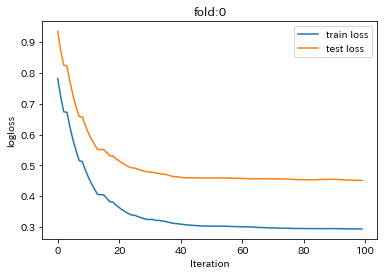

[I 2021-12-13 11:56:11,629] A new study created in memory with name: no-name-95fffcab-c7d9-47c6-a9e0-70aa3c76420f


Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:12,080] Trial 0 finished with value: 0.10719557951928363 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.10719557951928363.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131381	Test's rmse: 0.107196
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:12,425] Trial 1 finished with value: 0.13610145954023592 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.10719557951928363.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133052	Test's rmse: 0.136101
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:12,893] Trial 2 finished with value: 0.11199663372018694 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.10719557951928363.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148628	Test's rmse: 0.111997
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:13,337] Trial 3 finished with value: 0.11007959705896872 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.10719557951928363.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.146464	Test's rmse: 0.11008
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:13,644] Trial 4 finished with value: 0.13951428268921193 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.10719557951928363.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140926	Test's rmse: 0.139514
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:14,067] Trial 5 finished with value: 0.10971220492343477 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.10719557951928363.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128728	Test's rmse: 0.109712
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:14,437] Trial 6 finished with value: 0.12471472614397411 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.10719557951928363.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131213	Test's rmse: 0.124715
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:15,296] Trial 7 finished with value: 0.11168014841746274 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.11168014841746274.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129559	Test's rmse: 0.11168
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:16,953] Trial 8 finished with value: 0.11383454815256981 and parameters: {'num_leaves': 244}. Best is trial 7 with value: 0.11168014841746274.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131392	Test's rmse: 0.113835
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:18,365] Trial 9 finished with value: 0.11510543636411935 and parameters: {'num_leaves': 188}. Best is trial 7 with value: 0.11168014841746274.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136263	Test's rmse: 0.115105
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:19,570] Trial 10 finished with value: 0.11454364330454446 and parameters: {'num_leaves': 154}. Best is trial 7 with value: 0.11168014841746274.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136363	Test's rmse: 0.114544
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:20,077] Trial 11 finished with value: 0.10736038207062858 and parameters: {'num_leaves': 41}. Best is trial 11 with value: 0.10736038207062858.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130904	Test's rmse: 0.10736
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:20,551] Trial 12 finished with value: 0.10736038207062858 and parameters: {'num_leaves': 41}. Best is trial 11 with value: 0.10736038207062858.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130904	Test's rmse: 0.10736
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:20,836] Trial 13 finished with value: 0.10482006771573166 and parameters: {'num_leaves': 16}. Best is trial 13 with value: 0.10482006771573166.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133736	Test's rmse: 0.10482
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:22,410] Trial 14 finished with value: 0.11520343401506149 and parameters: {'num_leaves': 222}. Best is trial 13 with value: 0.10482006771573166.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136528	Test's rmse: 0.115203
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:23,617] Trial 15 finished with value: 0.11523802642655778 and parameters: {'num_leaves': 155}. Best is trial 13 with value: 0.10482006771573166.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136845	Test's rmse: 0.115238
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:24,950] Trial 16 finished with value: 0.11778026732914065 and parameters: {'num_leaves': 182}. Best is trial 13 with value: 0.10482006771573166.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133806	Test's rmse: 0.11778
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:25,162] Trial 17 finished with value: 0.11365085203225421 and parameters: {'num_leaves': 7}. Best is trial 13 with value: 0.10482006771573166.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138757	Test's rmse: 0.113651
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:25,855] Trial 18 finished with value: 0.11139938723096428 and parameters: {'num_leaves': 76}. Best is trial 13 with value: 0.10482006771573166.
[I 2021-12-13 11:56:26,008] Trial 19 finished with value: 0.1198610325151871 and parameters: {'num_leaves': 3}. Best is trial 13 with value: 0.10482006771573166.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131295	Test's rmse: 0.111399
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.199375	Test's rmse: 0.119861
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:26,620] Trial 20 finished with value: 0.1111797774077218 and parameters: {'num_leaves': 57}. Best is trial 13 with value: 0.10482006771573166.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129792	Test's rmse: 0.11118
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:27,560] Trial 21 finished with value: 0.11213485257708249 and parameters: {'num_leaves': 103}. Best is trial 13 with value: 0.10482006771573166.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129507	Test's rmse: 0.112135
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:28,022] Trial 22 finished with value: 0.10965788550435848 and parameters: {'num_leaves': 37}. Best is trial 13 with value: 0.10482006771573166.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129318	Test's rmse: 0.109658
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:28,408] Trial 23 finished with value: 0.1063156605544606 and parameters: {'num_leaves': 26}. Best is trial 13 with value: 0.10482006771573166.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133236	Test's rmse: 0.106316
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:29,367] Trial 24 finished with value: 0.11260798748678803 and parameters: {'num_leaves': 114}. Best is trial 13 with value: 0.10482006771573166.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134124	Test's rmse: 0.112608
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:30,043] Trial 25 finished with value: 0.11155948636134314 and parameters: {'num_leaves': 70}. Best is trial 13 with value: 0.10482006771573166.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137183	Test's rmse: 0.111559
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:30,330] Trial 26 finished with value: 0.10705654315556715 and parameters: {'num_leaves': 13}. Best is trial 13 with value: 0.10482006771573166.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134947	Test's rmse: 0.107057
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:30,648] Trial 27 finished with value: 0.1268345205996445 and parameters: {'bagging_fraction': 0.624724071308792, 'bagging_freq': 7}. Best is trial 27 with value: 0.1268345205996445.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.17764	Test's rmse: 0.126835
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:30,943] Trial 28 finished with value: 0.1175169234615188 and parameters: {'bagging_fraction': 0.8391963650875751, 'bagging_freq': 5}. Best is trial 28 with value: 0.1175169234615188.


Early stopping, best iteration is:
[40]	Train's rmse: 0.194961	Test's rmse: 0.117517
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:31,281] Trial 29 finished with value: 0.11295648619947704 and parameters: {'bagging_fraction': 0.49361118426561795, 'bagging_freq': 2}. Best is trial 29 with value: 0.11295648619947704.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.181189	Test's rmse: 0.112956
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:31,588] Trial 30 finished with value: 0.1201765339916017 and parameters: {'bagging_fraction': 0.4348501673009778, 'bagging_freq': 7}. Best is trial 29 with value: 0.11295648619947704.


Early stopping, best iteration is:
[46]	Train's rmse: 0.206894	Test's rmse: 0.120177
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:31,914] Trial 31 finished with value: 0.11811188218321204 and parameters: {'bagging_fraction': 0.7606690070465265, 'bagging_freq': 5}. Best is trial 29 with value: 0.11295648619947704.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.162737	Test's rmse: 0.118112
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:32,242] Trial 32 finished with value: 0.12592887637618774 and parameters: {'bagging_fraction': 0.41235069657750206, 'bagging_freq': 7}. Best is trial 29 with value: 0.11295648619947704.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.18813	Test's rmse: 0.125929
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:32,582] Trial 33 finished with value: 0.11288684731892161 and parameters: {'bagging_fraction': 0.8994655844810855, 'bagging_freq': 2}. Best is trial 33 with value: 0.11288684731892161.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144993	Test's rmse: 0.112887
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:32,911] Trial 34 finished with value: 0.10898688670688848 and parameters: {'bagging_fraction': 0.5090949803244422, 'bagging_freq': 2}. Best is trial 34 with value: 0.10898688670688848.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.178975	Test's rmse: 0.108987
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:33,275] Trial 35 finished with value: 0.12159787668073853 and parameters: {'bagging_fraction': 0.5825453457760269, 'bagging_freq': 4}. Best is trial 34 with value: 0.10898688670688848.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.176247	Test's rmse: 0.121598
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:33,620] Trial 36 finished with value: 0.11951769629470234 and parameters: {'bagging_fraction': 0.6591670111857015, 'bagging_freq': 3}. Best is trial 34 with value: 0.10898688670688848.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.166446	Test's rmse: 0.119518
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:33,894] Trial 37 finished with value: 0.1078120140640014 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 37 with value: 0.1078120140640014.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132174	Test's rmse: 0.107812
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:34,175] Trial 38 finished with value: 0.11231964835490808 and parameters: {'feature_fraction': 0.784}. Best is trial 37 with value: 0.1078120140640014.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129021	Test's rmse: 0.11232
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:34,479] Trial 39 finished with value: 0.10302056732983954 and parameters: {'feature_fraction': 0.88}. Best is trial 39 with value: 0.10302056732983954.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133425	Test's rmse: 0.103021
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:34,762] Trial 40 finished with value: 0.10482006771573166 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 39 with value: 0.10302056732983954.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133736	Test's rmse: 0.10482
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:35,048] Trial 41 finished with value: 0.10482006771573166 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 39 with value: 0.10302056732983954.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133736	Test's rmse: 0.10482
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:35,343] Trial 42 finished with value: 0.11231964835490808 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 39 with value: 0.10302056732983954.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129021	Test's rmse: 0.11232
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:35,634] Trial 43 finished with value: 0.11098490330825247 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403}. Best is trial 43 with value: 0.11098490330825247.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13971	Test's rmse: 0.110985
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:35,934] Trial 44 finished with value: 0.10618732403735559 and parameters: {'lambda_l1': 0.038720902953704193, 'lambda_l2': 0.0024430162614261413}. Best is trial 44 with value: 0.10618732403735559.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137995	Test's rmse: 0.106187
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:36,226] Trial 45 finished with value: 0.10302056748521506 and parameters: {'lambda_l1': 2.5361081166471375e-07, 'lambda_l2': 2.5348407664333426e-07}. Best is trial 45 with value: 0.10302056748521506.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133425	Test's rmse: 0.103021
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:36,536] Trial 46 finished with value: 0.10898490919673387 and parameters: {'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893}. Best is trial 45 with value: 0.10302056748521506.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133694	Test's rmse: 0.108985
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:36,831] Trial 47 finished with value: 0.10345083261507834 and parameters: {'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682}. Best is trial 45 with value: 0.10302056748521506.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133039	Test's rmse: 0.103451
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:37,119] Trial 48 finished with value: 0.10975003203631217 and parameters: {'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285}. Best is trial 45 with value: 0.10302056748521506.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143736	Test's rmse: 0.10975
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:37,423] Trial 49 finished with value: 0.10319695709152574 and parameters: {'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07}. Best is trial 45 with value: 0.10302056748521506.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133579	Test's rmse: 0.103197
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:37,728] Trial 50 finished with value: 0.10302056727099668 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07}. Best is trial 50 with value: 0.10302056727099668.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133425	Test's rmse: 0.103021
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:38,044] Trial 51 finished with value: 0.10302048826473512 and parameters: {'lambda_l1': 5.472429642032198e-06, 'lambda_l2': 0.00052821153945323}. Best is trial 51 with value: 0.10302048826473512.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133426	Test's rmse: 0.10302
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:38,339] Trial 52 finished with value: 0.10302059425332936 and parameters: {'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06}. Best is trial 51 with value: 0.10302048826473512.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133425	Test's rmse: 0.103021
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:38,653] Trial 53 finished with value: 0.1030205646095002 and parameters: {'lambda_l1': 6.340273805264716e-06, 'lambda_l2': 3.299511607801006e-05}. Best is trial 51 with value: 0.10302048826473512.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133425	Test's rmse: 0.103021
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:38,943] Trial 54 finished with value: 0.10302055530282722 and parameters: {'lambda_l1': 5.345719663255874e-06, 'lambda_l2': 9.060636202649443e-05}. Best is trial 51 with value: 0.10302048826473512.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133425	Test's rmse: 0.103021
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:39,242] Trial 55 finished with value: 0.10484684191563352 and parameters: {'lambda_l1': 0.0012317365144257704, 'lambda_l2': 0.00028537206253591963}. Best is trial 51 with value: 0.10302048826473512.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133277	Test's rmse: 0.104847
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:39,568] Trial 56 finished with value: 0.10533858742135713 and parameters: {'lambda_l1': 2.0766042477060265e-06, 'lambda_l2': 0.0157932370735966}. Best is trial 51 with value: 0.10302048826473512.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135826	Test's rmse: 0.105339
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:39,866] Trial 57 finished with value: 0.10302066797717327 and parameters: {'lambda_l1': 0.0002830080003726822, 'lambda_l2': 1.3139855587432983e-08}. Best is trial 51 with value: 0.10302048826473512.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133426	Test's rmse: 0.103021
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:40,147] Trial 58 finished with value: 0.11081054054486045 and parameters: {'lambda_l1': 5.103027507670196, 'lambda_l2': 0.00012746971990445138}. Best is trial 51 with value: 0.10302048826473512.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143188	Test's rmse: 0.110811
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:40,479] Trial 59 finished with value: 0.10484659759780904 and parameters: {'lambda_l1': 2.324554602370925e-06, 'lambda_l2': 0.0031036015624253425}. Best is trial 51 with value: 0.10302048826473512.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133276	Test's rmse: 0.104847
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:40,770] Trial 60 finished with value: 0.10302057861690711 and parameters: {'lambda_l1': 3.46878712082093e-05, 'lambda_l2': 7.321098518837269e-06}. Best is trial 51 with value: 0.10302048826473512.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133425	Test's rmse: 0.103021
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:41,086] Trial 61 finished with value: 0.10805525825678218 and parameters: {'lambda_l1': 2.757303879830078e-07, 'lambda_l2': 0.08102778728418951}. Best is trial 51 with value: 0.10302048826473512.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135526	Test's rmse: 0.108055
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:41,390] Trial 62 finished with value: 0.10295807743576686 and parameters: {'lambda_l1': 0.004844973425663015, 'lambda_l2': 0.001660936684817565}. Best is trial 62 with value: 0.10295807743576686.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134831	Test's rmse: 0.102958
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:41,696] Trial 63 finished with value: 0.1012409485426328 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.1012409485426328.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0749864	Test's rmse: 0.101241
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:42,008] Trial 64 finished with value: 0.18574866770653237 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.1012409485426328.


Early stopping, best iteration is:
[49]	Train's rmse: 0.260099	Test's rmse: 0.185749
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:42,263] Trial 65 finished with value: 0.1380785437705003 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.1012409485426328.


Early stopping, best iteration is:
[39]	Train's rmse: 0.0807657	Test's rmse: 0.138079
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:42,585] Trial 66 finished with value: 0.11098069537609356 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.1012409485426328.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154377	Test's rmse: 0.110981
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:42,832] Trial 67 finished with value: 0.22897696224758513 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.1012409485426328.


Early stopping, best iteration is:
[24]	Train's rmse: 0.337394	Test's rmse: 0.228977


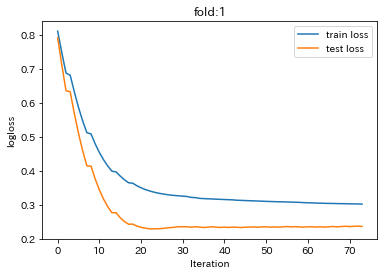

[I 2021-12-13 11:56:43,039] A new study created in memory with name: no-name-a74629ea-210d-4571-9d93-a4823cd6718d


Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:43,362] Trial 0 finished with value: 0.17464593003271933 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.17464593003271933.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140306	Test's rmse: 0.174646
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:43,769] Trial 1 finished with value: 0.14231731003631473 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 0.14231731003631473.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.124599	Test's rmse: 0.142317
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:44,187] Trial 2 finished with value: 0.13925631595127572 and parameters: {'feature_fraction': 0.8}. Best is trial 2 with value: 0.13925631595127572.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128875	Test's rmse: 0.139256
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:44,648] Trial 3 finished with value: 0.139473228921955 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 2 with value: 0.13925631595127572.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141856	Test's rmse: 0.139473
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:44,995] Trial 4 finished with value: 0.16167365823684848 and parameters: {'feature_fraction': 0.5}. Best is trial 2 with value: 0.13925631595127572.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130492	Test's rmse: 0.161674
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:45,453] Trial 5 finished with value: 0.14150262343439804 and parameters: {'feature_fraction': 1.0}. Best is trial 2 with value: 0.13925631595127572.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.146988	Test's rmse: 0.141503
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:45,837] Trial 6 finished with value: 0.1442742824485471 and parameters: {'feature_fraction': 0.6}. Best is trial 2 with value: 0.13925631595127572.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.123915	Test's rmse: 0.144274
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:46,687] Trial 7 finished with value: 0.14630680319500106 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.14630680319500106.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139733	Test's rmse: 0.146307
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:48,363] Trial 8 finished with value: 0.1491971436334064 and parameters: {'num_leaves': 244}. Best is trial 7 with value: 0.14630680319500106.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133802	Test's rmse: 0.149197
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:49,775] Trial 9 finished with value: 0.14912360810456546 and parameters: {'num_leaves': 188}. Best is trial 7 with value: 0.14630680319500106.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135435	Test's rmse: 0.149124
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:50,971] Trial 10 finished with value: 0.14521368590807787 and parameters: {'num_leaves': 154}. Best is trial 10 with value: 0.14521368590807787.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136445	Test's rmse: 0.145214
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:51,454] Trial 11 finished with value: 0.14443932022891917 and parameters: {'num_leaves': 41}. Best is trial 11 with value: 0.14443932022891917.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138036	Test's rmse: 0.144439
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:51,951] Trial 12 finished with value: 0.14443932022891917 and parameters: {'num_leaves': 41}. Best is trial 11 with value: 0.14443932022891917.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138036	Test's rmse: 0.144439
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:52,247] Trial 13 finished with value: 0.14130179768870463 and parameters: {'num_leaves': 16}. Best is trial 13 with value: 0.14130179768870463.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.123726	Test's rmse: 0.141302
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:53,815] Trial 14 finished with value: 0.1489908500800281 and parameters: {'num_leaves': 222}. Best is trial 13 with value: 0.14130179768870463.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136839	Test's rmse: 0.148991
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:55,007] Trial 15 finished with value: 0.14601426096992637 and parameters: {'num_leaves': 155}. Best is trial 13 with value: 0.14130179768870463.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138026	Test's rmse: 0.146014
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:56,360] Trial 16 finished with value: 0.14655343968325088 and parameters: {'num_leaves': 182}. Best is trial 13 with value: 0.14130179768870463.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133016	Test's rmse: 0.146553
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:56,553] Trial 17 finished with value: 0.1477562938075823 and parameters: {'num_leaves': 7}. Best is trial 13 with value: 0.14130179768870463.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.1325	Test's rmse: 0.147756
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:57,289] Trial 18 finished with value: 0.14549598112770595 and parameters: {'num_leaves': 76}. Best is trial 13 with value: 0.14130179768870463.
[I 2021-12-13 11:56:57,438] Trial 19 finished with value: 0.16269649760226693 and parameters: {'num_leaves': 3}. Best is trial 13 with value: 0.14130179768870463.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13448	Test's rmse: 0.145496
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.199713	Test's rmse: 0.162696
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:58,048] Trial 20 finished with value: 0.14344032340350074 and parameters: {'num_leaves': 57}. Best is trial 13 with value: 0.14130179768870463.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131985	Test's rmse: 0.14344
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:58,888] Trial 21 finished with value: 0.1458488789794424 and parameters: {'num_leaves': 91}. Best is trial 13 with value: 0.14130179768870463.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131912	Test's rmse: 0.145849
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:56:59,439] Trial 22 finished with value: 0.14186725445271522 and parameters: {'num_leaves': 47}. Best is trial 13 with value: 0.14130179768870463.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136075	Test's rmse: 0.141867
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:00,437] Trial 23 finished with value: 0.1474424158648623 and parameters: {'num_leaves': 119}. Best is trial 13 with value: 0.14130179768870463.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13841	Test's rmse: 0.147442
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:00,872] Trial 24 finished with value: 0.14351612846567185 and parameters: {'num_leaves': 32}. Best is trial 13 with value: 0.14130179768870463.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140096	Test's rmse: 0.143516
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:01,562] Trial 25 finished with value: 0.14219825947271214 and parameters: {'num_leaves': 68}. Best is trial 13 with value: 0.14130179768870463.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133931	Test's rmse: 0.142198
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:01,861] Trial 26 finished with value: 0.1425377642722612 and parameters: {'num_leaves': 14}. Best is trial 13 with value: 0.14130179768870463.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127461	Test's rmse: 0.142538
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:02,343] Trial 27 finished with value: 0.16310487380891445 and parameters: {'bagging_fraction': 0.624724071308792, 'bagging_freq': 7}. Best is trial 27 with value: 0.16310487380891445.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.163166	Test's rmse: 0.163105
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:02,827] Trial 28 finished with value: 0.15518285491290318 and parameters: {'bagging_fraction': 0.8391963650875751, 'bagging_freq': 5}. Best is trial 28 with value: 0.15518285491290318.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.151943	Test's rmse: 0.155183
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:03,261] Trial 29 finished with value: 0.15894201523799784 and parameters: {'bagging_fraction': 0.49361118426561795, 'bagging_freq': 2}. Best is trial 28 with value: 0.15518285491290318.


Early stopping, best iteration is:
[35]	Train's rmse: 0.207583	Test's rmse: 0.158942
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:03,728] Trial 30 finished with value: 0.15106925878005636 and parameters: {'bagging_fraction': 0.4348501673009778, 'bagging_freq': 7}. Best is trial 30 with value: 0.15106925878005636.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.178765	Test's rmse: 0.151069
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:04,227] Trial 31 finished with value: 0.1543334450756596 and parameters: {'bagging_fraction': 0.7606690070465265, 'bagging_freq': 5}. Best is trial 30 with value: 0.15106925878005636.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.160793	Test's rmse: 0.154333
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:04,682] Trial 32 finished with value: 0.1526267504438698 and parameters: {'bagging_fraction': 0.41235069657750206, 'bagging_freq': 7}. Best is trial 30 with value: 0.15106925878005636.


Did not meet early stopping. Best iteration is:
[96]	Train's rmse: 0.185135	Test's rmse: 0.152627
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:05,210] Trial 33 finished with value: 0.14927828511720734 and parameters: {'bagging_fraction': 0.8994655844810855, 'bagging_freq': 2}. Best is trial 33 with value: 0.14927828511720734.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145306	Test's rmse: 0.149278
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:05,691] Trial 34 finished with value: 0.15944730767924767 and parameters: {'bagging_fraction': 0.5090949803244422, 'bagging_freq': 2}. Best is trial 33 with value: 0.14927828511720734.


Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.175664	Test's rmse: 0.159447
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:06,194] Trial 35 finished with value: 0.15434256215833772 and parameters: {'bagging_fraction': 0.5825453457760269, 'bagging_freq': 4}. Best is trial 33 with value: 0.14927828511720734.


Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.170882	Test's rmse: 0.154343
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:06,673] Trial 36 finished with value: 0.15278106633916602 and parameters: {'bagging_fraction': 0.6591670111857015, 'bagging_freq': 3}. Best is trial 33 with value: 0.14927828511720734.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.164543	Test's rmse: 0.152781
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:07,131] Trial 37 finished with value: 0.13925631595127572 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 37 with value: 0.13925631595127572.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128875	Test's rmse: 0.139256
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:07,511] Trial 38 finished with value: 0.14231731003631473 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 37 with value: 0.13925631595127572.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.124599	Test's rmse: 0.142317
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:07,933] Trial 39 finished with value: 0.14161883447338924 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 37 with value: 0.13925631595127572.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142468	Test's rmse: 0.141619
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:08,385] Trial 40 finished with value: 0.14161883447338924 and parameters: {'feature_fraction': 0.88}. Best is trial 37 with value: 0.13925631595127572.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142468	Test's rmse: 0.141619
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:08,790] Trial 41 finished with value: 0.14149331685906763 and parameters: {'feature_fraction': 0.784}. Best is trial 37 with value: 0.13925631595127572.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.122336	Test's rmse: 0.141493
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:09,205] Trial 42 finished with value: 0.14149331685906763 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 37 with value: 0.13925631595127572.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.122336	Test's rmse: 0.141493
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:09,615] Trial 43 finished with value: 0.15391867801855197 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403}. Best is trial 43 with value: 0.15391867801855197.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132844	Test's rmse: 0.153919
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:10,022] Trial 44 finished with value: 0.14307167349040642 and parameters: {'lambda_l1': 0.038720902953704193, 'lambda_l2': 0.0024430162614261413}. Best is trial 44 with value: 0.14307167349040642.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138081	Test's rmse: 0.143072
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:10,453] Trial 45 finished with value: 0.13925631653874074 and parameters: {'lambda_l1': 2.5361081166471375e-07, 'lambda_l2': 2.5348407664333426e-07}. Best is trial 45 with value: 0.13925631653874074.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128875	Test's rmse: 0.139256
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:10,856] Trial 46 finished with value: 0.14464888451299818 and parameters: {'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893}. Best is trial 45 with value: 0.13925631653874074.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139212	Test's rmse: 0.144649
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:11,285] Trial 47 finished with value: 0.1431396720399117 and parameters: {'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682}. Best is trial 45 with value: 0.13925631653874074.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13541	Test's rmse: 0.14314
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:11,700] Trial 48 finished with value: 0.15256696137280926 and parameters: {'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285}. Best is trial 45 with value: 0.13925631653874074.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131993	Test's rmse: 0.152567
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:12,092] Trial 49 finished with value: 0.14350421860214582 and parameters: {'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07}. Best is trial 45 with value: 0.13925631653874074.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13418	Test's rmse: 0.143504
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:12,532] Trial 50 finished with value: 0.13925631697289753 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07}. Best is trial 45 with value: 0.13925631653874074.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128875	Test's rmse: 0.139256
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:12,959] Trial 51 finished with value: 0.13925587413886542 and parameters: {'lambda_l1': 5.472429642032198e-06, 'lambda_l2': 0.00052821153945323}. Best is trial 51 with value: 0.13925587413886542.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128874	Test's rmse: 0.139256
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:13,394] Trial 52 finished with value: 0.14347378684668602 and parameters: {'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06}. Best is trial 51 with value: 0.13925587413886542.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135955	Test's rmse: 0.143474
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:13,799] Trial 53 finished with value: 0.13925633794622058 and parameters: {'lambda_l1': 6.340273805264716e-06, 'lambda_l2': 3.299511607801006e-05}. Best is trial 51 with value: 0.13925587413886542.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128875	Test's rmse: 0.139256
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:14,238] Trial 54 finished with value: 0.13925631766390562 and parameters: {'lambda_l1': 1.0975246698422151e-06, 'lambda_l2': 1.700171186192954e-08}. Best is trial 51 with value: 0.13925587413886542.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128875	Test's rmse: 0.139256
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:14,654] Trial 55 finished with value: 0.14353250179235272 and parameters: {'lambda_l1': 0.0012317365144257704, 'lambda_l2': 0.0005019490480004477}. Best is trial 51 with value: 0.13925587413886542.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137924	Test's rmse: 0.143533
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:15,061] Trial 56 finished with value: 0.13925631689871312 and parameters: {'lambda_l1': 5.880895197454503e-07, 'lambda_l2': 1.2702524155028834e-08}. Best is trial 51 with value: 0.13925587413886542.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128875	Test's rmse: 0.139256
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:15,485] Trial 57 finished with value: 0.13925632768510385 and parameters: {'lambda_l1': 1.299413633838622e-07, 'lambda_l2': 3.018374194095203e-05}. Best is trial 51 with value: 0.13925587413886542.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128875	Test's rmse: 0.139256
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:15,833] Trial 58 finished with value: 0.15290747141958697 and parameters: {'lambda_l1': 5.103027507670196, 'lambda_l2': 0.018810618912109483}. Best is trial 51 with value: 0.13925587413886542.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139762	Test's rmse: 0.152907
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:16,263] Trial 59 finished with value: 0.13925635496925154 and parameters: {'lambda_l1': 5.767463313261697e-06, 'lambda_l2': 7.95728542519163e-05}. Best is trial 51 with value: 0.13925587413886542.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128875	Test's rmse: 0.139256
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:16,676] Trial 60 finished with value: 0.14346302608609127 and parameters: {'lambda_l1': 0.00021730362290175211, 'lambda_l2': 0.002218478115831345}. Best is trial 51 with value: 0.13925587413886542.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135551	Test's rmse: 0.143463
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:17,083] Trial 61 finished with value: 0.1392563336125288 and parameters: {'lambda_l1': 1.1927813096355353e-05, 'lambda_l2': 2.5408716217151766e-07}. Best is trial 51 with value: 0.13925587413886542.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128875	Test's rmse: 0.139256
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:17,506] Trial 62 finished with value: 0.13925631806962685 and parameters: {'lambda_l1': 8.519122560508412e-08, 'lambda_l2': 5.089764879993183e-06}. Best is trial 51 with value: 0.13925587413886542.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128875	Test's rmse: 0.139256
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:17,899] Trial 63 finished with value: 0.1489386623395622 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.1489386623395622.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.029139	Test's rmse: 0.148939
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:18,294] Trial 64 finished with value: 0.14812786684995266 and parameters: {'min_child_samples': 10}. Best is trial 64 with value: 0.14812786684995266.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0667697	Test's rmse: 0.148128
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:18,727] Trial 65 finished with value: 0.19640238376714364 and parameters: {'min_child_samples': 100}. Best is trial 64 with value: 0.14812786684995266.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.28422	Test's rmse: 0.196402
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:19,144] Trial 66 finished with value: 0.1513810082706101 and parameters: {'min_child_samples': 25}. Best is trial 64 with value: 0.14812786684995266.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148865	Test's rmse: 0.151381
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:19,597] Trial 67 finished with value: 0.17592033520877362 and parameters: {'min_child_samples': 50}. Best is trial 64 with value: 0.14812786684995266.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.230442	Test's rmse: 0.17592


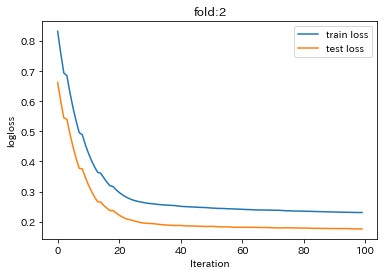

[I 2021-12-13 11:57:19,806] A new study created in memory with name: no-name-1c582971-17c5-4def-b79c-672254bfb7f4


Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:20,130] Trial 0 finished with value: 0.10615833108191376 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.10615833108191376.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142166	Test's rmse: 0.106158
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:20,528] Trial 1 finished with value: 0.08328249485144172 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.08328249485144172.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13123	Test's rmse: 0.0832825
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:20,885] Trial 2 finished with value: 0.10061889839855907 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 0.08328249485144172.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137443	Test's rmse: 0.100619
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:21,311] Trial 3 finished with value: 0.02177254108325357 and parameters: {'feature_fraction': 1.0}. Best is trial 3 with value: 0.02177254108325357.


Early stopping, best iteration is:
[43]	Train's rmse: 0.165773	Test's rmse: 0.0217725
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:21,746] Trial 4 finished with value: 0.047424802730389466 and parameters: {'feature_fraction': 0.8}. Best is trial 3 with value: 0.02177254108325357.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12607	Test's rmse: 0.0474248
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:22,188] Trial 5 finished with value: 0.03958827496350937 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 3 with value: 0.02177254108325357.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.153403	Test's rmse: 0.0395883
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:22,585] Trial 6 finished with value: 0.06638633431207216 and parameters: {'feature_fraction': 0.7}. Best is trial 3 with value: 0.02177254108325357.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132491	Test's rmse: 0.0663863
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:23,481] Trial 7 finished with value: 0.02188603484912839 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.02188603484912839.


Early stopping, best iteration is:
[47]	Train's rmse: 0.164193	Test's rmse: 0.021886
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:25,050] Trial 8 finished with value: 0.022159563169070542 and parameters: {'num_leaves': 244}. Best is trial 7 with value: 0.02188603484912839.


Early stopping, best iteration is:
[45]	Train's rmse: 0.165303	Test's rmse: 0.0221596
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:26,380] Trial 9 finished with value: 0.022149152421570728 and parameters: {'num_leaves': 188}. Best is trial 7 with value: 0.02188603484912839.


Early stopping, best iteration is:
[45]	Train's rmse: 0.165304	Test's rmse: 0.0221492
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:27,627] Trial 10 finished with value: 0.02202955210451074 and parameters: {'num_leaves': 154}. Best is trial 7 with value: 0.02188603484912839.


Early stopping, best iteration is:
[47]	Train's rmse: 0.164775	Test's rmse: 0.0220296
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:28,125] Trial 11 finished with value: 0.022568339423283842 and parameters: {'num_leaves': 41}. Best is trial 7 with value: 0.02188603484912839.


Early stopping, best iteration is:
[42]	Train's rmse: 0.167063	Test's rmse: 0.0225683
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:28,643] Trial 12 finished with value: 0.022568339423283842 and parameters: {'num_leaves': 41}. Best is trial 7 with value: 0.02188603484912839.


Early stopping, best iteration is:
[42]	Train's rmse: 0.167063	Test's rmse: 0.0225683
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:28,932] Trial 13 finished with value: 0.02028532114968275 and parameters: {'num_leaves': 16}. Best is trial 13 with value: 0.02028532114968275.


Early stopping, best iteration is:
[43]	Train's rmse: 0.164398	Test's rmse: 0.0202853
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:30,407] Trial 14 finished with value: 0.022151878274247406 and parameters: {'num_leaves': 222}. Best is trial 13 with value: 0.02028532114968275.


Early stopping, best iteration is:
[45]	Train's rmse: 0.165303	Test's rmse: 0.0221519
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:31,581] Trial 15 finished with value: 0.022057199281079656 and parameters: {'num_leaves': 155}. Best is trial 13 with value: 0.02028532114968275.


Early stopping, best iteration is:
[45]	Train's rmse: 0.165916	Test's rmse: 0.0220572
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:32,859] Trial 16 finished with value: 0.022167796260155814 and parameters: {'num_leaves': 182}. Best is trial 13 with value: 0.02028532114968275.


Early stopping, best iteration is:
[43]	Train's rmse: 0.166137	Test's rmse: 0.0221678
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:33,084] Trial 17 finished with value: 0.02479507423804576 and parameters: {'num_leaves': 7}. Best is trial 13 with value: 0.02028532114968275.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.153094	Test's rmse: 0.0247951
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:33,864] Trial 18 finished with value: 0.021937645253101278 and parameters: {'num_leaves': 82}. Best is trial 13 with value: 0.02028532114968275.


Early stopping, best iteration is:
[47]	Train's rmse: 0.164804	Test's rmse: 0.0219376
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:34,809] Trial 19 finished with value: 0.022667395962731707 and parameters: {'num_leaves': 109}. Best is trial 13 with value: 0.02028532114968275.


Early stopping, best iteration is:
[49]	Train's rmse: 0.161368	Test's rmse: 0.0226674
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:35,557] Trial 20 finished with value: 0.022134591309460785 and parameters: {'num_leaves': 86}. Best is trial 13 with value: 0.02028532114968275.


Early stopping, best iteration is:
[42]	Train's rmse: 0.167388	Test's rmse: 0.0221346
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:35,803] Trial 21 finished with value: 0.021353008637956243 and parameters: {'num_leaves': 10}. Best is trial 13 with value: 0.02028532114968275.


Early stopping, best iteration is:
[42]	Train's rmse: 0.168897	Test's rmse: 0.021353
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:36,061] Trial 22 finished with value: 0.021198904765390037 and parameters: {'num_leaves': 11}. Best is trial 13 with value: 0.02028532114968275.


Early stopping, best iteration is:
[44]	Train's rmse: 0.16384	Test's rmse: 0.0211989
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:36,611] Trial 23 finished with value: 0.021416775164908104 and parameters: {'num_leaves': 54}. Best is trial 13 with value: 0.02028532114968275.
[I 2021-12-13 11:57:36,790] Trial 24 finished with value: 0.027631011581862396 and parameters: {'num_leaves': 4}. Best is trial 13 with value: 0.02028532114968275.


Early stopping, best iteration is:
[44]	Train's rmse: 0.165823	Test's rmse: 0.0214168
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.173566	Test's rmse: 0.027631
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:37,344] Trial 25 finished with value: 0.022287558440883364 and parameters: {'num_leaves': 55}. Best is trial 13 with value: 0.02028532114968275.


Early stopping, best iteration is:
[42]	Train's rmse: 0.169267	Test's rmse: 0.0222876
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:37,712] Trial 26 finished with value: 0.021935765796860674 and parameters: {'num_leaves': 27}. Best is trial 13 with value: 0.02028532114968275.


Early stopping, best iteration is:
[43]	Train's rmse: 0.165192	Test's rmse: 0.0219358
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:38,052] Trial 27 finished with value: 0.028377536898577613 and parameters: {'bagging_fraction': 0.624724071308792, 'bagging_freq': 7}. Best is trial 27 with value: 0.028377536898577613.


Early stopping, best iteration is:
[42]	Train's rmse: 0.189295	Test's rmse: 0.0283775
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:38,398] Trial 28 finished with value: 0.025655071282711127 and parameters: {'bagging_fraction': 0.8391963650875751, 'bagging_freq': 5}. Best is trial 28 with value: 0.025655071282711127.


Early stopping, best iteration is:
[45]	Train's rmse: 0.183122	Test's rmse: 0.0256551
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:38,732] Trial 29 finished with value: 0.03162890065128707 and parameters: {'bagging_fraction': 0.49361118426561795, 'bagging_freq': 2}. Best is trial 28 with value: 0.025655071282711127.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.183401	Test's rmse: 0.0316289
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:39,077] Trial 30 finished with value: 0.027769673153485358 and parameters: {'bagging_fraction': 0.4348501673009778, 'bagging_freq': 7}. Best is trial 28 with value: 0.025655071282711127.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.184988	Test's rmse: 0.0277697
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:39,433] Trial 31 finished with value: 0.031091627426969463 and parameters: {'bagging_fraction': 0.7606690070465265, 'bagging_freq': 5}. Best is trial 28 with value: 0.025655071282711127.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.180404	Test's rmse: 0.0310916
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:39,787] Trial 32 finished with value: 0.03114422196281981 and parameters: {'bagging_fraction': 0.41235069657750206, 'bagging_freq': 7}. Best is trial 28 with value: 0.025655071282711127.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.189551	Test's rmse: 0.0311442
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:40,170] Trial 33 finished with value: 0.02341670171381725 and parameters: {'bagging_fraction': 0.8994655844810855, 'bagging_freq': 2}. Best is trial 33 with value: 0.02341670171381725.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.160485	Test's rmse: 0.0234167
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:40,514] Trial 34 finished with value: 0.029592574284096767 and parameters: {'bagging_fraction': 0.5090949803244422, 'bagging_freq': 2}. Best is trial 33 with value: 0.02341670171381725.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.18027	Test's rmse: 0.0295926
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:40,867] Trial 35 finished with value: 0.030859048692057165 and parameters: {'bagging_fraction': 0.5825453457760269, 'bagging_freq': 4}. Best is trial 33 with value: 0.02341670171381725.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.180018	Test's rmse: 0.030859
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:41,214] Trial 36 finished with value: 0.03611675344426076 and parameters: {'bagging_fraction': 0.6591670111857015, 'bagging_freq': 3}. Best is trial 33 with value: 0.02341670171381725.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174537	Test's rmse: 0.0361168
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:41,524] Trial 37 finished with value: 0.03670097413484493 and parameters: {'feature_fraction': 0.92}. Best is trial 37 with value: 0.03670097413484493.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15056	Test's rmse: 0.036701
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:41,839] Trial 38 finished with value: 0.03423979092835321 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 38 with value: 0.03423979092835321.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.151535	Test's rmse: 0.0342398
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:42,151] Trial 39 finished with value: 0.03423979092835321 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 38 with value: 0.03423979092835321.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.151535	Test's rmse: 0.0342398
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:42,446] Trial 40 finished with value: 0.02558174159986648 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403}. Best is trial 40 with value: 0.02558174159986648.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.149375	Test's rmse: 0.0255817
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:42,740] Trial 41 finished with value: 0.019831101860476746 and parameters: {'lambda_l1': 0.038720902953704193, 'lambda_l2': 0.0024430162614261413}. Best is trial 41 with value: 0.019831101860476746.


Early stopping, best iteration is:
[49]	Train's rmse: 0.16803	Test's rmse: 0.0198311
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:43,053] Trial 42 finished with value: 0.02028532112992294 and parameters: {'lambda_l1': 2.5361081166471375e-07, 'lambda_l2': 2.5348407664333426e-07}. Best is trial 41 with value: 0.019831101860476746.


Early stopping, best iteration is:
[43]	Train's rmse: 0.164398	Test's rmse: 0.0202853
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:43,328] Trial 43 finished with value: 0.022249044425101897 and parameters: {'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893}. Best is trial 41 with value: 0.019831101860476746.


Early stopping, best iteration is:
[43]	Train's rmse: 0.166682	Test's rmse: 0.022249
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:43,605] Trial 44 finished with value: 0.020678068175480867 and parameters: {'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682}. Best is trial 41 with value: 0.019831101860476746.


Early stopping, best iteration is:
[44]	Train's rmse: 0.167822	Test's rmse: 0.0206781
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:43,903] Trial 45 finished with value: 0.02655309409846946 and parameters: {'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285}. Best is trial 41 with value: 0.019831101860476746.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152523	Test's rmse: 0.0265531
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:44,178] Trial 46 finished with value: 0.021323513723116787 and parameters: {'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07}. Best is trial 41 with value: 0.019831101860476746.


Early stopping, best iteration is:
[47]	Train's rmse: 0.161151	Test's rmse: 0.0213235
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:44,454] Trial 47 finished with value: 0.020285321107039605 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07}. Best is trial 41 with value: 0.019831101860476746.


Early stopping, best iteration is:
[43]	Train's rmse: 0.164398	Test's rmse: 0.0202853
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:44,733] Trial 48 finished with value: 0.02028519908828651 and parameters: {'lambda_l1': 5.472429642032198e-06, 'lambda_l2': 0.00052821153945323}. Best is trial 41 with value: 0.019831101860476746.


Early stopping, best iteration is:
[43]	Train's rmse: 0.164399	Test's rmse: 0.0202852
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:45,034] Trial 49 finished with value: 0.02028533069921708 and parameters: {'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06}. Best is trial 41 with value: 0.019831101860476746.


Early stopping, best iteration is:
[43]	Train's rmse: 0.164398	Test's rmse: 0.0202853
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:45,315] Trial 50 finished with value: 0.031101599405707118 and parameters: {'lambda_l1': 5.402896923508629, 'lambda_l2': 0.00018194741639177489}. Best is trial 41 with value: 0.019831101860476746.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143604	Test's rmse: 0.0311016
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:45,614] Trial 51 finished with value: 0.020372057056134124 and parameters: {'lambda_l1': 0.004908301797490369, 'lambda_l2': 0.0009771589136000017}. Best is trial 41 with value: 0.019831101860476746.


Early stopping, best iteration is:
[44]	Train's rmse: 0.166499	Test's rmse: 0.0203721
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:45,914] Trial 52 finished with value: 0.02893382725571422 and parameters: {'lambda_l1': 0.06708272946489857, 'lambda_l2': 0.0003108365361430203}. Best is trial 41 with value: 0.019831101860476746.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.149054	Test's rmse: 0.0289338
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:46,213] Trial 53 finished with value: 0.020283892162995153 and parameters: {'lambda_l1': 3.601966653030624e-06, 'lambda_l2': 0.006152049296214337}. Best is trial 41 with value: 0.019831101860476746.


Early stopping, best iteration is:
[43]	Train's rmse: 0.164404	Test's rmse: 0.0202839
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:46,518] Trial 54 finished with value: 0.029447324328788455 and parameters: {'lambda_l1': 0.0008472745658933207, 'lambda_l2': 0.044223173270844754}. Best is trial 41 with value: 0.019831101860476746.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145035	Test's rmse: 0.0294473
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:46,785] Trial 55 finished with value: 0.02018530929924569 and parameters: {'lambda_l1': 0.05503926305649259, 'lambda_l2': 0.011297359459467275}. Best is trial 41 with value: 0.019831101860476746.


Early stopping, best iteration is:
[43]	Train's rmse: 0.169378	Test's rmse: 0.0201853
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:47,079] Trial 56 finished with value: 0.022356922830272182 and parameters: {'lambda_l1': 0.06469738195422284, 'lambda_l2': 2.2689003690072427e-05}. Best is trial 41 with value: 0.019831101860476746.


Early stopping, best iteration is:
[45]	Train's rmse: 0.16451	Test's rmse: 0.0223569
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:47,347] Trial 57 finished with value: 0.02659284993399035 and parameters: {'lambda_l1': 8.232907602810837, 'lambda_l2': 0.118760751687072}. Best is trial 41 with value: 0.019831101860476746.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.146601	Test's rmse: 0.0265928
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:47,624] Trial 58 finished with value: 0.02716728195420249 and parameters: {'lambda_l1': 0.6112729537386181, 'lambda_l2': 0.0035747862607187334}. Best is trial 41 with value: 0.019831101860476746.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137149	Test's rmse: 0.0271673
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:47,919] Trial 59 finished with value: 0.020372012610499143 and parameters: {'lambda_l1': 0.006269224708411151, 'lambda_l2': 3.0785615192833e-05}. Best is trial 41 with value: 0.019831101860476746.


Early stopping, best iteration is:
[44]	Train's rmse: 0.166499	Test's rmse: 0.020372
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:48,225] Trial 60 finished with value: 0.026766902156243468 and parameters: {'min_child_samples': 10}. Best is trial 60 with value: 0.026766902156243468.


Early stopping, best iteration is:
[39]	Train's rmse: 0.114847	Test's rmse: 0.0267669
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:48,500] Trial 61 finished with value: 0.05583387012256648 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 0.026766902156243468.


Early stopping, best iteration is:
[39]	Train's rmse: 0.25747	Test's rmse: 0.0558339
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:48,753] Trial 62 finished with value: 0.08968622604426872 and parameters: {'min_child_samples': 100}. Best is trial 60 with value: 0.026766902156243468.


Early stopping, best iteration is:
[29]	Train's rmse: 0.318707	Test's rmse: 0.0896862
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:49,017] Trial 63 finished with value: 0.024702041414483 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.024702041414483.


Early stopping, best iteration is:
[45]	Train's rmse: 0.051623	Test's rmse: 0.024702
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:49,331] Trial 64 finished with value: 0.027326852225812572 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.024702041414483.


Early stopping, best iteration is:
[44]	Train's rmse: 0.175669	Test's rmse: 0.0273269


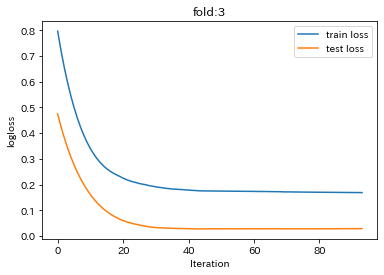

[I 2021-12-13 11:57:49,542] A new study created in memory with name: no-name-499b4eda-2b68-4575-8b7d-d4f419692e50


Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:49,963] Trial 0 finished with value: 0.38854610452293914 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.38854610452293914.


Early stopping, best iteration is:
[48]	Train's rmse: 0.15319	Test's rmse: 0.388546
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:50,365] Trial 1 finished with value: 0.37303280377763515 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 0.37303280377763515.


Early stopping, best iteration is:
[32]	Train's rmse: 0.15906	Test's rmse: 0.373033
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:50,708] Trial 2 finished with value: 0.41325813010412743 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 0.37303280377763515.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.121666	Test's rmse: 0.413258
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:51,114] Trial 3 finished with value: 0.407667454479844 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.37303280377763515.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119068	Test's rmse: 0.407667
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:51,507] Trial 4 finished with value: 0.39792690629008476 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 0.37303280377763515.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119956	Test's rmse: 0.397927
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:51,886] Trial 5 finished with value: 0.38020058278906177 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 0.37303280377763515.


Early stopping, best iteration is:
[36]	Train's rmse: 0.157903	Test's rmse: 0.380201
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:52,229] Trial 6 finished with value: 0.41194801855330004 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 0.37303280377763515.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127532	Test's rmse: 0.411948
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:52,953] Trial 7 finished with value: 0.37606495936578405 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.37606495936578405.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159187	Test's rmse: 0.376065
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:54,431] Trial 8 finished with value: 0.3757680455073839 and parameters: {'num_leaves': 244}. Best is trial 8 with value: 0.3757680455073839.


Early stopping, best iteration is:
[39]	Train's rmse: 0.153025	Test's rmse: 0.375768
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:55,645] Trial 9 finished with value: 0.37576783200939284 and parameters: {'num_leaves': 188}. Best is trial 9 with value: 0.37576783200939284.


Early stopping, best iteration is:
[39]	Train's rmse: 0.153026	Test's rmse: 0.375768
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:56,653] Trial 10 finished with value: 0.37608682300129176 and parameters: {'num_leaves': 154}. Best is trial 9 with value: 0.37576783200939284.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159181	Test's rmse: 0.376087
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:57,083] Trial 11 finished with value: 0.37614593179128814 and parameters: {'num_leaves': 41}. Best is trial 9 with value: 0.37576783200939284.


Early stopping, best iteration is:
[31]	Train's rmse: 0.159713	Test's rmse: 0.376146
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:57,547] Trial 12 finished with value: 0.37614593179128814 and parameters: {'num_leaves': 41}. Best is trial 9 with value: 0.37576783200939284.


Early stopping, best iteration is:
[31]	Train's rmse: 0.159713	Test's rmse: 0.376146
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:57,813] Trial 13 finished with value: 0.37581947967179347 and parameters: {'num_leaves': 16}. Best is trial 9 with value: 0.37576783200939284.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159073	Test's rmse: 0.375819
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:57:59,053] Trial 14 finished with value: 0.376064196302643 and parameters: {'num_leaves': 222}. Best is trial 9 with value: 0.37576783200939284.


Early stopping, best iteration is:
[32]	Train's rmse: 0.15918	Test's rmse: 0.376064
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:00,129] Trial 15 finished with value: 0.37578044138282113 and parameters: {'num_leaves': 155}. Best is trial 9 with value: 0.37576783200939284.


Early stopping, best iteration is:
[39]	Train's rmse: 0.153026	Test's rmse: 0.37578
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:01,358] Trial 16 finished with value: 0.3757805317973913 and parameters: {'num_leaves': 182}. Best is trial 9 with value: 0.37576783200939284.


Early stopping, best iteration is:
[39]	Train's rmse: 0.153025	Test's rmse: 0.375781
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:02,036] Trial 17 finished with value: 0.3760715859919916 and parameters: {'num_leaves': 83}. Best is trial 9 with value: 0.37576783200939284.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159194	Test's rmse: 0.376072
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:03,532] Trial 18 finished with value: 0.3757680785901596 and parameters: {'num_leaves': 246}. Best is trial 9 with value: 0.37576783200939284.


Early stopping, best iteration is:
[39]	Train's rmse: 0.153025	Test's rmse: 0.375768
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:04,843] Trial 19 finished with value: 0.3757680089310986 and parameters: {'num_leaves': 210}. Best is trial 9 with value: 0.37576783200939284.


Early stopping, best iteration is:
[39]	Train's rmse: 0.153026	Test's rmse: 0.375768
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:06,097] Trial 20 finished with value: 0.37576801571108703 and parameters: {'num_leaves': 198}. Best is trial 9 with value: 0.37576783200939284.


Early stopping, best iteration is:
[39]	Train's rmse: 0.153026	Test's rmse: 0.375768
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:07,332] Trial 21 finished with value: 0.3757679231119786 and parameters: {'num_leaves': 195}. Best is trial 9 with value: 0.37576783200939284.


Early stopping, best iteration is:
[39]	Train's rmse: 0.153026	Test's rmse: 0.375768
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:08,347] Trial 22 finished with value: 0.3760866286752516 and parameters: {'num_leaves': 164}. Best is trial 9 with value: 0.37576783200939284.


Early stopping, best iteration is:
[32]	Train's rmse: 0.15918	Test's rmse: 0.376087
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:09,248] Trial 23 finished with value: 0.3757688371248756 and parameters: {'num_leaves': 118}. Best is trial 9 with value: 0.37576783200939284.


Early stopping, best iteration is:
[39]	Train's rmse: 0.153049	Test's rmse: 0.375769
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:10,262] Trial 24 finished with value: 0.3757660303044145 and parameters: {'num_leaves': 133}. Best is trial 24 with value: 0.3757660303044145.


Early stopping, best iteration is:
[39]	Train's rmse: 0.153043	Test's rmse: 0.375766
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:11,151] Trial 25 finished with value: 0.3760694402302203 and parameters: {'num_leaves': 128}. Best is trial 24 with value: 0.3757660303044145.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159187	Test's rmse: 0.376069
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:11,809] Trial 26 finished with value: 0.3760715859919916 and parameters: {'num_leaves': 83}. Best is trial 24 with value: 0.3757660303044145.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159194	Test's rmse: 0.376072
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:12,309] Trial 27 finished with value: 0.34371253974240007 and parameters: {'bagging_fraction': 0.624724071308792, 'bagging_freq': 7}. Best is trial 27 with value: 0.34371253974240007.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.163307	Test's rmse: 0.343713
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:12,862] Trial 28 finished with value: 0.36534671822946113 and parameters: {'bagging_fraction': 0.8391963650875751, 'bagging_freq': 5}. Best is trial 27 with value: 0.34371253974240007.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148738	Test's rmse: 0.365347
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:13,363] Trial 29 finished with value: 0.34742904615597364 and parameters: {'bagging_fraction': 0.49361118426561795, 'bagging_freq': 2}. Best is trial 27 with value: 0.34371253974240007.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.170648	Test's rmse: 0.347429
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:13,865] Trial 30 finished with value: 0.35416751163143156 and parameters: {'bagging_fraction': 0.4348501673009778, 'bagging_freq': 7}. Best is trial 27 with value: 0.34371253974240007.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172984	Test's rmse: 0.354168
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:14,373] Trial 31 finished with value: 0.3498543739047216 and parameters: {'bagging_fraction': 0.7606690070465265, 'bagging_freq': 5}. Best is trial 27 with value: 0.34371253974240007.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.156355	Test's rmse: 0.349854
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:14,883] Trial 32 finished with value: 0.3467172499435282 and parameters: {'bagging_fraction': 0.41235069657750206, 'bagging_freq': 7}. Best is trial 27 with value: 0.34371253974240007.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.175652	Test's rmse: 0.346717
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:15,426] Trial 33 finished with value: 0.36553766555594686 and parameters: {'bagging_fraction': 0.8994655844810855, 'bagging_freq': 2}. Best is trial 27 with value: 0.34371253974240007.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142873	Test's rmse: 0.365538
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:15,945] Trial 34 finished with value: 0.346570884433672 and parameters: {'bagging_fraction': 0.5090949803244422, 'bagging_freq': 2}. Best is trial 27 with value: 0.34371253974240007.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.167761	Test's rmse: 0.346571
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:16,452] Trial 35 finished with value: 0.35808848165876905 and parameters: {'bagging_fraction': 0.5825453457760269, 'bagging_freq': 4}. Best is trial 27 with value: 0.34371253974240007.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.164895	Test's rmse: 0.358088
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:16,989] Trial 36 finished with value: 0.35568093472165413 and parameters: {'bagging_fraction': 0.6591670111857015, 'bagging_freq': 3}. Best is trial 27 with value: 0.34371253974240007.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.161961	Test's rmse: 0.355681
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:17,436] Trial 37 finished with value: 0.33478641343252435 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 37 with value: 0.33478641343252435.


Early stopping, best iteration is:
[42]	Train's rmse: 0.182187	Test's rmse: 0.334786
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:17,889] Trial 38 finished with value: 0.3367757112907181 and parameters: {'feature_fraction': 0.92}. Best is trial 37 with value: 0.33478641343252435.


Early stopping, best iteration is:
[42]	Train's rmse: 0.180929	Test's rmse: 0.336776
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:18,335] Trial 39 finished with value: 0.33478641343252435 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 37 with value: 0.33478641343252435.


Early stopping, best iteration is:
[42]	Train's rmse: 0.182187	Test's rmse: 0.334786
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:18,761] Trial 40 finished with value: 0.3289138759158339 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403}. Best is trial 40 with value: 0.3289138759158339.


Early stopping, best iteration is:
[41]	Train's rmse: 0.185573	Test's rmse: 0.328914
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:19,211] Trial 41 finished with value: 0.33279872092710383 and parameters: {'lambda_l1': 0.038720902953704193, 'lambda_l2': 0.0024430162614261413}. Best is trial 40 with value: 0.3289138759158339.


Early stopping, best iteration is:
[45]	Train's rmse: 0.183113	Test's rmse: 0.332799
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:19,673] Trial 42 finished with value: 0.3347864136928929 and parameters: {'lambda_l1': 2.5361081166471375e-07, 'lambda_l2': 2.5348407664333426e-07}. Best is trial 40 with value: 0.3289138759158339.


Early stopping, best iteration is:
[42]	Train's rmse: 0.182187	Test's rmse: 0.334786
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:20,138] Trial 43 finished with value: 0.33543290734859266 and parameters: {'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893}. Best is trial 40 with value: 0.3289138759158339.


Early stopping, best iteration is:
[42]	Train's rmse: 0.183468	Test's rmse: 0.335433
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:20,588] Trial 44 finished with value: 0.33696573169268845 and parameters: {'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682}. Best is trial 40 with value: 0.3289138759158339.


Early stopping, best iteration is:
[42]	Train's rmse: 0.18245	Test's rmse: 0.336966
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:21,029] Trial 45 finished with value: 0.32866262307047606 and parameters: {'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285}. Best is trial 45 with value: 0.32866262307047606.


Early stopping, best iteration is:
[42]	Train's rmse: 0.187358	Test's rmse: 0.328663
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:21,484] Trial 46 finished with value: 0.34892769275340707 and parameters: {'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07}. Best is trial 45 with value: 0.32866262307047606.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.159863	Test's rmse: 0.348928
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:21,948] Trial 47 finished with value: 0.3347864139397379 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07}. Best is trial 45 with value: 0.32866262307047606.


Early stopping, best iteration is:
[42]	Train's rmse: 0.182187	Test's rmse: 0.334786
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:22,401] Trial 48 finished with value: 0.3347867924972309 and parameters: {'lambda_l1': 5.472429642032198e-06, 'lambda_l2': 0.00052821153945323}. Best is trial 45 with value: 0.32866262307047606.


Early stopping, best iteration is:
[42]	Train's rmse: 0.182187	Test's rmse: 0.334787
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:22,854] Trial 49 finished with value: 0.3347864910949965 and parameters: {'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06}. Best is trial 45 with value: 0.32866262307047606.


Early stopping, best iteration is:
[42]	Train's rmse: 0.182187	Test's rmse: 0.334786
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:23,216] Trial 50 finished with value: 0.3341713031970957 and parameters: {'lambda_l1': 3.207959657544482, 'lambda_l2': 0.08430920984585018}. Best is trial 45 with value: 0.32866262307047606.


Early stopping, best iteration is:
[41]	Train's rmse: 0.180045	Test's rmse: 0.334171
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:23,628] Trial 51 finished with value: 0.33084219637715473 and parameters: {'lambda_l1': 1.1692997958212103e-08, 'lambda_l2': 3.9472261531899844}. Best is trial 45 with value: 0.32866262307047606.


Early stopping, best iteration is:
[41]	Train's rmse: 0.185021	Test's rmse: 0.330842
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:24,125] Trial 52 finished with value: 0.34279143254561206 and parameters: {'lambda_l1': 5.045896527823807e-05, 'lambda_l2': 2.5658581133290594}. Best is trial 45 with value: 0.32866262307047606.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.163352	Test's rmse: 0.342791
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:24,588] Trial 53 finished with value: 0.33293710315021513 and parameters: {'lambda_l1': 0.002030128714530023, 'lambda_l2': 3.404677878190547e-05}. Best is trial 45 with value: 0.32866262307047606.


Early stopping, best iteration is:
[42]	Train's rmse: 0.184981	Test's rmse: 0.332937
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:25,058] Trial 54 finished with value: 0.3347864172849034 and parameters: {'lambda_l1': 4.078898004558595e-06, 'lambda_l2': 1.3139855587432983e-08}. Best is trial 45 with value: 0.32866262307047606.


Early stopping, best iteration is:
[42]	Train's rmse: 0.182187	Test's rmse: 0.334786
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:25,515] Trial 55 finished with value: 0.33544338780330935 and parameters: {'lambda_l1': 3.3639426888455315e-06, 'lambda_l2': 0.09582202435248795}. Best is trial 45 with value: 0.32866262307047606.


Early stopping, best iteration is:
[42]	Train's rmse: 0.183218	Test's rmse: 0.335443
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:25,935] Trial 56 finished with value: 0.33492604873180987 and parameters: {'lambda_l1': 1.4649890622159385e-07, 'lambda_l2': 8.462570930314385}. Best is trial 45 with value: 0.32866262307047606.


Early stopping, best iteration is:
[42]	Train's rmse: 0.189344	Test's rmse: 0.334926
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:26,412] Trial 57 finished with value: 0.3369984776741806 and parameters: {'lambda_l1': 0.00027462567466751464, 'lambda_l2': 0.004118303286085666}. Best is trial 45 with value: 0.32866262307047606.


Early stopping, best iteration is:
[42]	Train's rmse: 0.182404	Test's rmse: 0.336998
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:26,906] Trial 58 finished with value: 0.3433684868056914 and parameters: {'lambda_l1': 0.005075666193958132, 'lambda_l2': 0.40769457646520396}. Best is trial 45 with value: 0.32866262307047606.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.160864	Test's rmse: 0.343368
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:27,416] Trial 59 finished with value: 0.3451988182138368 and parameters: {'lambda_l1': 1.92023307742427e-05, 'lambda_l2': 0.44768902954732587}. Best is trial 45 with value: 0.32866262307047606.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.161867	Test's rmse: 0.345199
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:27,832] Trial 60 finished with value: 0.3890595488174642 and parameters: {'min_child_samples': 5}. Best is trial 60 with value: 0.3890595488174642.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0745016	Test's rmse: 0.38906
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:28,337] Trial 61 finished with value: 0.35153284753045216 and parameters: {'min_child_samples': 25}. Best is trial 61 with value: 0.35153284753045216.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16912	Test's rmse: 0.351533
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:28,769] Trial 62 finished with value: 0.36345065158452006 and parameters: {'min_child_samples': 10}. Best is trial 61 with value: 0.35153284753045216.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.120339	Test's rmse: 0.363451
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:29,255] Trial 63 finished with value: 0.5230916389575654 and parameters: {'min_child_samples': 100}. Best is trial 61 with value: 0.35153284753045216.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.269202	Test's rmse: 0.523092
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:29,732] Trial 64 finished with value: 0.4299150006410031 and parameters: {'min_child_samples': 50}. Best is trial 61 with value: 0.35153284753045216.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.215422	Test's rmse: 0.429915


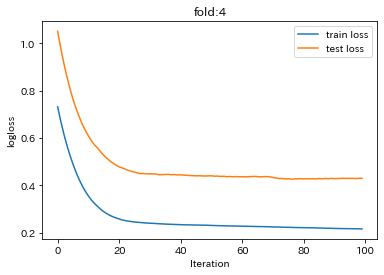

RMSE: [0.32230317840558415, 0.10124094806106895, 0.13925587714931634, 0.01983110070837394, 0.3286626227023894]
RMSE: 0.18225874540534653
elapsed_time:163.0[sec]


In [ ]:
# 経過時間の測定
start = time.time()

y_train = y_train.reset_index(drop=True)

# 学習・推論
gkf = GroupKFold(n_splits=5)

groups = X_train_ce["Genre"]

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': 'rmse',             # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'deterministic':True,         # 再現性確保用のパラメータ
          'force_row_wise':True,        # 再現性確保用のパラメータ
          'seed': SEED                  # シード値
          }

best_params, history = {}, []

cv_result = []

for fold, (train_index, test_index) in enumerate(gkf.split(X_train_ce, y_train, groups)):
    X_train_gkf, X_test_gkf = X_train_ce.iloc[train_index], X_train_ce.iloc[test_index]
    y_train_gkf, y_test_gkf = y_train.iloc[train_index], y_train.iloc[test_index]

    # 学習、推論
    lgb_train = lgb.Dataset(X_train_gkf, y_train_gkf)
    lgb_test = lgb.Dataset(X_test_gkf, y_test_gkf, reference=lgb_train)

    lgb_results = {}                                    # 学習の履歴を入れる入物

    model = lgb.LightGBMTuner(
                    params,                           # ハイパーパラメータをセット
                    train_set = lgb_train,            # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    early_stopping_rounds=50,         # アーリーストッピング設定
                    evals_result=lgb_results,
                    show_progress_bar = False,        # プログレスバーの非表示
                    verbose_eval=-1,                  # ログを最後の1つだけ表示
                    optuna_seed=SEED,
                    )

    # 訓練の実施
    model.run()
    
    best_params = model.best_params
    best_model = model.get_best_booster()

   # 損失推移を表示
    loss_train = lgb_results['Train']['rmse']
    loss_test = lgb_results['Test']['rmse']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('logloss')

    plt.title(f"fold:{fold}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='test loss')
    
    plt.legend()
    plt.show()

    # 推論
    y_pred = best_model.predict(X_test_gkf)

    # 評価
    rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
    cv_result.append(rmse)

print("RMSE:", cv_result)
print("RMSE:", np.mean(cv_result))

# 経過時間の測定
elasped_time = round((time.time() - start), 1)

print(f"elapsed_time:{elasped_time}[sec]")

## 量子化

In [ ]:
X_train_ce = X_train_ce.astype(np.float16)

y_train = y_train.astype(np.float16)

In [ ]:
# 目的変数
print(y_train.dtypes)

# 説明変数
display(pd.DataFrame(X_train_ce.dtypes).T)

float16


,Rank,Name,basename,Genre,ESRB_Rating_E,ESRB_Rating_T,ESRB_Rating_M,ESRB_Rating_E10,ESRB_Rating_EC,ESRB_Rating_RP,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,User_Score,Total_Shipped,Year,Last_Update,url,status,Vgchartzscore,img_url
0,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16


[I 2021-12-13 11:58:30,086] A new study created in memory with name: no-name-a45e22d4-f783-490f-93c1-550761b2f7ed


Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:30,454] Trial 0 finished with value: 0.3623497007234342 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.3623497007234342.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.109368	Test's rmse: 0.36235
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:30,755] Trial 1 finished with value: 0.3554970658668534 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 0.3554970658668534.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.121119	Test's rmse: 0.355497
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:31,181] Trial 2 finished with value: 0.3503695933559308 and parameters: {'feature_fraction': 0.7}. Best is trial 2 with value: 0.3503695933559308.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.108025	Test's rmse: 0.35037
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:31,610] Trial 3 finished with value: 0.3480744199008333 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 3 with value: 0.3480744199008333.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.121824	Test's rmse: 0.348074
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:31,946] Trial 4 finished with value: 0.3610304178366811 and parameters: {'feature_fraction': 0.5}. Best is trial 3 with value: 0.3480744199008333.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.117376	Test's rmse: 0.36103
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:32,376] Trial 5 finished with value: 0.34110275357210224 and parameters: {'feature_fraction': 1.0}. Best is trial 5 with value: 0.34110275357210224.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.125304	Test's rmse: 0.341103
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:32,793] Trial 6 finished with value: 0.34832348751558 and parameters: {'feature_fraction': 0.8}. Best is trial 5 with value: 0.34110275357210224.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.108773	Test's rmse: 0.348323
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:33,657] Trial 7 finished with value: 0.3421814461333646 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.3421814461333646.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126769	Test's rmse: 0.342181
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:35,413] Trial 8 finished with value: 0.34019666285218825 and parameters: {'num_leaves': 244}. Best is trial 8 with value: 0.34019666285218825.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126068	Test's rmse: 0.340197
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:36,885] Trial 9 finished with value: 0.3401786270845154 and parameters: {'num_leaves': 188}. Best is trial 9 with value: 0.3401786270845154.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126075	Test's rmse: 0.340179
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:38,131] Trial 10 finished with value: 0.340190552836485 and parameters: {'num_leaves': 154}. Best is trial 9 with value: 0.3401786270845154.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126092	Test's rmse: 0.340191
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:38,650] Trial 11 finished with value: 0.34049866909890486 and parameters: {'num_leaves': 41}. Best is trial 9 with value: 0.3401786270845154.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.125531	Test's rmse: 0.340499
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:39,157] Trial 12 finished with value: 0.34049866909890486 and parameters: {'num_leaves': 41}. Best is trial 9 with value: 0.3401786270845154.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.125531	Test's rmse: 0.340499
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:39,474] Trial 13 finished with value: 0.3426532542532187 and parameters: {'num_leaves': 16}. Best is trial 9 with value: 0.3401786270845154.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.125713	Test's rmse: 0.342653
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:41,081] Trial 14 finished with value: 0.34019778165759207 and parameters: {'num_leaves': 222}. Best is trial 9 with value: 0.3401786270845154.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126078	Test's rmse: 0.340198
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:42,352] Trial 15 finished with value: 0.3402610873224442 and parameters: {'num_leaves': 155}. Best is trial 9 with value: 0.3401786270845154.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126051	Test's rmse: 0.340261
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:43,746] Trial 16 finished with value: 0.33780942260549135 and parameters: {'num_leaves': 182}. Best is trial 16 with value: 0.33780942260549135.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127004	Test's rmse: 0.337809
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:44,537] Trial 17 finished with value: 0.3424157659962062 and parameters: {'num_leaves': 81}. Best is trial 16 with value: 0.33780942260549135.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12584	Test's rmse: 0.342416
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:46,001] Trial 18 finished with value: 0.3380435535243253 and parameters: {'num_leaves': 196}. Best is trial 16 with value: 0.33780942260549135.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126897	Test's rmse: 0.338044
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:47,406] Trial 19 finished with value: 0.3401990418837113 and parameters: {'num_leaves': 179}. Best is trial 16 with value: 0.33780942260549135.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126101	Test's rmse: 0.340199
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:48,923] Trial 20 finished with value: 0.3402739993141551 and parameters: {'num_leaves': 206}. Best is trial 16 with value: 0.33780942260549135.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126007	Test's rmse: 0.340274
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:49,954] Trial 21 finished with value: 0.34040014785163125 and parameters: {'num_leaves': 118}. Best is trial 16 with value: 0.33780942260549135.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.125815	Test's rmse: 0.3404
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:51,665] Trial 22 finished with value: 0.34021062847426303 and parameters: {'num_leaves': 233}. Best is trial 16 with value: 0.33780942260549135.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126056	Test's rmse: 0.340211
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:52,956] Trial 23 finished with value: 0.3402578747415502 and parameters: {'num_leaves': 162}. Best is trial 16 with value: 0.33780942260549135.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12612	Test's rmse: 0.340258
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:54,072] Trial 24 finished with value: 0.3380774520827825 and parameters: {'num_leaves': 133}. Best is trial 16 with value: 0.33780942260549135.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127079	Test's rmse: 0.338077
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:55,572] Trial 25 finished with value: 0.3401849440083589 and parameters: {'num_leaves': 201}. Best is trial 16 with value: 0.33780942260549135.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126035	Test's rmse: 0.340185
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:57,381] Trial 26 finished with value: 0.3402337884504624 and parameters: {'num_leaves': 255}. Best is trial 16 with value: 0.33780942260549135.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126066	Test's rmse: 0.340234
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:58:58,917] Trial 27 finished with value: 0.32248398220540947 and parameters: {'bagging_fraction': 0.624724071308792, 'bagging_freq': 7}. Best is trial 27 with value: 0.32248398220540947.


Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.160786	Test's rmse: 0.322484
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:00,473] Trial 28 finished with value: 0.3410416073667306 and parameters: {'bagging_fraction': 0.8391963650875751, 'bagging_freq': 5}. Best is trial 27 with value: 0.32248398220540947.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.146361	Test's rmse: 0.341042
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:02,003] Trial 29 finished with value: 0.32320859884684977 and parameters: {'bagging_fraction': 0.49361118426561795, 'bagging_freq': 2}. Best is trial 27 with value: 0.32248398220540947.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.160976	Test's rmse: 0.323209
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:03,463] Trial 30 finished with value: 0.32617259565163087 and parameters: {'bagging_fraction': 0.4348501673009778, 'bagging_freq': 7}. Best is trial 27 with value: 0.32248398220540947.


Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.169285	Test's rmse: 0.326173
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:05,000] Trial 31 finished with value: 0.31709039499749175 and parameters: {'bagging_fraction': 0.7606690070465265, 'bagging_freq': 5}. Best is trial 31 with value: 0.31709039499749175.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.150932	Test's rmse: 0.31709
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:06,415] Trial 32 finished with value: 0.33545891725317944 and parameters: {'bagging_fraction': 0.41235069657750206, 'bagging_freq': 7}. Best is trial 31 with value: 0.31709039499749175.


Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.170224	Test's rmse: 0.335459
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:07,963] Trial 33 finished with value: 0.32992230847118986 and parameters: {'bagging_fraction': 0.8994655844810855, 'bagging_freq': 2}. Best is trial 31 with value: 0.31709039499749175.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138949	Test's rmse: 0.329922
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:09,461] Trial 34 finished with value: 0.3154282314432624 and parameters: {'bagging_fraction': 0.5090949803244422, 'bagging_freq': 2}. Best is trial 34 with value: 0.3154282314432624.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.159631	Test's rmse: 0.315428
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:10,953] Trial 35 finished with value: 0.3305695260957857 and parameters: {'bagging_fraction': 0.5825453457760269, 'bagging_freq': 4}. Best is trial 34 with value: 0.3154282314432624.


Early stopping, best iteration is:
[49]	Train's rmse: 0.164996	Test's rmse: 0.33057
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:12,483] Trial 36 finished with value: 0.32076409629515146 and parameters: {'bagging_fraction': 0.6591670111857015, 'bagging_freq': 3}. Best is trial 34 with value: 0.3154282314432624.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.157653	Test's rmse: 0.320764
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:13,959] Trial 37 finished with value: 0.31540691868993315 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 37 with value: 0.31540691868993315.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.158317	Test's rmse: 0.315407
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:15,423] Trial 38 finished with value: 0.31540691868993315 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 37 with value: 0.31540691868993315.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.158317	Test's rmse: 0.315407
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:16,864] Trial 39 finished with value: 0.31450746683772784 and parameters: {'feature_fraction': 0.92}. Best is trial 39 with value: 0.31450746683772784.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.156792	Test's rmse: 0.314507
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:18,086] Trial 40 finished with value: 0.32256069295162015 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403}. Best is trial 40 with value: 0.32256069295162015.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.156007	Test's rmse: 0.322561
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:19,337] Trial 41 finished with value: 0.3176035420947783 and parameters: {'lambda_l1': 0.038720902953704193, 'lambda_l2': 0.0024430162614261413}. Best is trial 41 with value: 0.3176035420947783.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.155635	Test's rmse: 0.317604
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:20,776] Trial 42 finished with value: 0.31474529132461615 and parameters: {'lambda_l1': 2.5361081166471375e-07, 'lambda_l2': 2.5348407664333426e-07}. Best is trial 42 with value: 0.31474529132461615.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.156734	Test's rmse: 0.314745
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:22,120] Trial 43 finished with value: 0.3123315737183188 and parameters: {'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893}. Best is trial 43 with value: 0.3123315737183188.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154865	Test's rmse: 0.312332
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:23,589] Trial 44 finished with value: 0.31523129953658374 and parameters: {'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682}. Best is trial 43 with value: 0.3123315737183188.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.156771	Test's rmse: 0.315231
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:24,793] Trial 45 finished with value: 0.322364847493381 and parameters: {'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285}. Best is trial 43 with value: 0.3123315737183188.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.158056	Test's rmse: 0.322365
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:25,621] Trial 46 finished with value: 0.3177805941762353 and parameters: {'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07}. Best is trial 43 with value: 0.3123315737183188.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154242	Test's rmse: 0.317781
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:27,066] Trial 47 finished with value: 0.31479479623616413 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07}. Best is trial 43 with value: 0.3123315737183188.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.156748	Test's rmse: 0.314795
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:28,518] Trial 48 finished with value: 0.31681903629029845 and parameters: {'lambda_l1': 5.472429642032198e-06, 'lambda_l2': 0.00052821153945323}. Best is trial 43 with value: 0.3123315737183188.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.156721	Test's rmse: 0.316819
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:29,973] Trial 49 finished with value: 0.3166986458574861 and parameters: {'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06}. Best is trial 43 with value: 0.3123315737183188.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.156011	Test's rmse: 0.316699
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:30,377] Trial 50 finished with value: 0.3360315842761803 and parameters: {'lambda_l1': 3.207959657544482, 'lambda_l2': 0.09866694315446872}. Best is trial 43 with value: 0.3123315737183188.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.156336	Test's rmse: 0.336032
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:31,851] Trial 51 finished with value: 0.31450746690674647 and parameters: {'lambda_l1': 1.1692997958212103e-08, 'lambda_l2': 1.700171186192954e-08}. Best is trial 43 with value: 0.3123315737183188.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.156792	Test's rmse: 0.314507
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:33,300] Trial 52 finished with value: 0.3151902203889039 and parameters: {'lambda_l1': 1.3512777353940762e-08, 'lambda_l2': 2.3120208094961207e-05}. Best is trial 43 with value: 0.3123315737183188.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.156841	Test's rmse: 0.31519
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:34,748] Trial 53 finished with value: 0.31479479611002353 and parameters: {'lambda_l1': 5.541518974002406e-07, 'lambda_l2': 2.35740695190084e-08}. Best is trial 43 with value: 0.3123315737183188.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.156748	Test's rmse: 0.314795
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:36,254] Trial 54 finished with value: 0.3178284912400097 and parameters: {'lambda_l1': 0.0013643656722816411, 'lambda_l2': 1.1508217261645661e-08}. Best is trial 43 with value: 0.3123315737183188.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.156404	Test's rmse: 0.317828
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:37,715] Trial 55 finished with value: 0.31519023604291607 and parameters: {'lambda_l1': 1.1916519926516243e-08, 'lambda_l2': 4.624083095518924e-05}. Best is trial 43 with value: 0.3123315737183188.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.156841	Test's rmse: 0.31519
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:39,120] Trial 56 finished with value: 0.31815588740492523 and parameters: {'lambda_l1': 3.7384258928166384e-06, 'lambda_l2': 0.1304964127901967}. Best is trial 43 with value: 0.3123315737183188.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.157222	Test's rmse: 0.318156
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:40,575] Trial 57 finished with value: 0.3149187395086192 and parameters: {'lambda_l1': 1.8796187625037182e-07, 'lambda_l2': 0.0039440907858195725}. Best is trial 43 with value: 0.3123315737183188.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.156587	Test's rmse: 0.314919
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:41,942] Trial 58 finished with value: 0.31703758394269826 and parameters: {'lambda_l1': 1.197340518782296e-07, 'lambda_l2': 0.5361615285304203}. Best is trial 43 with value: 0.3123315737183188.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154043	Test's rmse: 0.317038
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:43,400] Trial 59 finished with value: 0.3136449548818419 and parameters: {'lambda_l1': 2.528830125346676e-06, 'lambda_l2': 0.00010244181483444618}. Best is trial 43 with value: 0.3123315737183188.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.156896	Test's rmse: 0.313645
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:44,718] Trial 60 finished with value: 0.3353394658457979 and parameters: {'min_child_samples': 25}. Best is trial 60 with value: 0.3353394658457979.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.158666	Test's rmse: 0.335339
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:46,209] Trial 61 finished with value: 0.32139922243696595 and parameters: {'min_child_samples': 10}. Best is trial 61 with value: 0.32139922243696595.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.113127	Test's rmse: 0.321399
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:47,676] Trial 62 finished with value: 0.3181387725181999 and parameters: {'min_child_samples': 5}. Best is trial 62 with value: 0.3181387725181999.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0528903	Test's rmse: 0.318139
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:48,311] Trial 63 finished with value: 0.4494753825616316 and parameters: {'min_child_samples': 100}. Best is trial 62 with value: 0.3181387725181999.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.302453	Test's rmse: 0.449475
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:49,172] Trial 64 finished with value: 0.379101650428129 and parameters: {'min_child_samples': 50}. Best is trial 62 with value: 0.3181387725181999.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.22576	Test's rmse: 0.379102


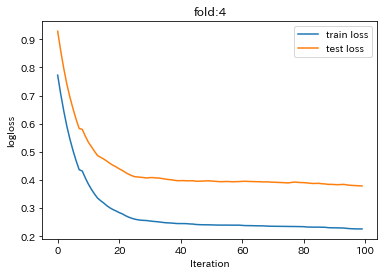

[I 2021-12-13 11:59:49,402] A new study created in memory with name: no-name-6ea3c00b-d075-4693-900a-c9ef76c48ce6


Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:49,817] Trial 0 finished with value: 0.11370046206405457 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.11370046206405457.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130973	Test's rmse: 0.1137
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:50,225] Trial 1 finished with value: 0.11515457756365548 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.11370046206405457.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132142	Test's rmse: 0.115155
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:50,599] Trial 2 finished with value: 0.12334788776154507 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.11370046206405457.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129353	Test's rmse: 0.123348
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:50,972] Trial 3 finished with value: 0.14064428930661618 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.11370046206405457.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14085	Test's rmse: 0.140644
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:51,285] Trial 4 finished with value: 0.1344648646354615 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.11370046206405457.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138408	Test's rmse: 0.134465
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:51,735] Trial 5 finished with value: 0.10511044639140006 and parameters: {'feature_fraction': 1.0}. Best is trial 5 with value: 0.10511044639140006.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.158535	Test's rmse: 0.10511
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:52,183] Trial 6 finished with value: 0.10807358289291293 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 5 with value: 0.10511044639140006.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154694	Test's rmse: 0.108074
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:53,102] Trial 7 finished with value: 0.10424764682009634 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.10424764682009634.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15703	Test's rmse: 0.104248
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:54,854] Trial 8 finished with value: 0.10400478470193121 and parameters: {'num_leaves': 244}. Best is trial 8 with value: 0.10400478470193121.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.157053	Test's rmse: 0.104005
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:56,357] Trial 9 finished with value: 0.10429608717248676 and parameters: {'num_leaves': 188}. Best is trial 8 with value: 0.10400478470193121.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.157071	Test's rmse: 0.104296
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:57,642] Trial 10 finished with value: 0.10391114729168234 and parameters: {'num_leaves': 154}. Best is trial 10 with value: 0.10391114729168234.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.157162	Test's rmse: 0.103911
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:58,186] Trial 11 finished with value: 0.10420331261560474 and parameters: {'num_leaves': 41}. Best is trial 10 with value: 0.10391114729168234.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.157203	Test's rmse: 0.104203
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:58,693] Trial 12 finished with value: 0.10420331261560474 and parameters: {'num_leaves': 41}. Best is trial 10 with value: 0.10391114729168234.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.157203	Test's rmse: 0.104203
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 11:59:58,991] Trial 13 finished with value: 0.10792495660131807 and parameters: {'num_leaves': 16}. Best is trial 10 with value: 0.10391114729168234.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.157072	Test's rmse: 0.107925
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:00,655] Trial 14 finished with value: 0.10395212898068626 and parameters: {'num_leaves': 222}. Best is trial 10 with value: 0.10391114729168234.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.157042	Test's rmse: 0.103952
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:01,961] Trial 15 finished with value: 0.10388142880646321 and parameters: {'num_leaves': 155}. Best is trial 15 with value: 0.10388142880646321.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15715	Test's rmse: 0.103881
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:03,424] Trial 16 finished with value: 0.10406566783718518 and parameters: {'num_leaves': 182}. Best is trial 15 with value: 0.10388142880646321.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.157157	Test's rmse: 0.104066
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:04,415] Trial 17 finished with value: 0.10417056012889422 and parameters: {'num_leaves': 110}. Best is trial 15 with value: 0.10388142880646321.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.156979	Test's rmse: 0.104171
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:05,667] Trial 18 finished with value: 0.10398407993271964 and parameters: {'num_leaves': 149}. Best is trial 15 with value: 0.10388142880646321.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.157145	Test's rmse: 0.103984
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:06,937] Trial 19 finished with value: 0.10422502431295069 and parameters: {'num_leaves': 152}. Best is trial 15 with value: 0.10388142880646321.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.157158	Test's rmse: 0.104225
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:07,783] Trial 20 finished with value: 0.10426867163754916 and parameters: {'num_leaves': 84}. Best is trial 15 with value: 0.10388142880646321.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.157126	Test's rmse: 0.104269
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:09,251] Trial 21 finished with value: 0.1040068814256966 and parameters: {'num_leaves': 190}. Best is trial 15 with value: 0.10388142880646321.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15705	Test's rmse: 0.104007
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:10,420] Trial 22 finished with value: 0.10419254986150894 and parameters: {'num_leaves': 132}. Best is trial 15 with value: 0.10388142880646321.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.156994	Test's rmse: 0.104193
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:11,746] Trial 23 finished with value: 0.10402550771630723 and parameters: {'num_leaves': 168}. Best is trial 15 with value: 0.10388142880646321.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.157154	Test's rmse: 0.104026
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:13,342] Trial 24 finished with value: 0.10399344170765096 and parameters: {'num_leaves': 216}. Best is trial 15 with value: 0.10388142880646321.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.157045	Test's rmse: 0.103993
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:14,390] Trial 25 finished with value: 0.1040965836914316 and parameters: {'num_leaves': 122}. Best is trial 15 with value: 0.10388142880646321.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.157134	Test's rmse: 0.104097
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:15,170] Trial 26 finished with value: 0.10408629013924565 and parameters: {'num_leaves': 79}. Best is trial 15 with value: 0.10388142880646321.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.157176	Test's rmse: 0.104086
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:16,564] Trial 27 finished with value: 0.11753139890517349 and parameters: {'bagging_fraction': 0.624724071308792, 'bagging_freq': 7}. Best is trial 27 with value: 0.11753139890517349.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.186613	Test's rmse: 0.117531
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:17,723] Trial 28 finished with value: 0.10260567817971805 and parameters: {'bagging_fraction': 0.8391963650875751, 'bagging_freq': 5}. Best is trial 28 with value: 0.10260567817971805.


Early stopping, best iteration is:
[39]	Train's rmse: 0.189115	Test's rmse: 0.102606
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:19,095] Trial 29 finished with value: 0.1085052517904983 and parameters: {'bagging_fraction': 0.49361118426561795, 'bagging_freq': 2}. Best is trial 28 with value: 0.10260567817971805.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.185138	Test's rmse: 0.108505
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:20,210] Trial 30 finished with value: 0.11187418321118339 and parameters: {'bagging_fraction': 0.4348501673009778, 'bagging_freq': 7}. Best is trial 28 with value: 0.10260567817971805.


Early stopping, best iteration is:
[37]	Train's rmse: 0.211565	Test's rmse: 0.111874
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:21,584] Trial 31 finished with value: 0.10523135617448758 and parameters: {'bagging_fraction': 0.7606690070465265, 'bagging_freq': 5}. Best is trial 28 with value: 0.10260567817971805.


Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.17753	Test's rmse: 0.105231
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:22,883] Trial 32 finished with value: 0.11766633768952689 and parameters: {'bagging_fraction': 0.41235069657750206, 'bagging_freq': 7}. Best is trial 28 with value: 0.10260567817971805.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.198129	Test's rmse: 0.117666
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:24,272] Trial 33 finished with value: 0.11026709424411978 and parameters: {'bagging_fraction': 0.8994655844810855, 'bagging_freq': 2}. Best is trial 28 with value: 0.10260567817971805.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16389	Test's rmse: 0.110267
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:25,625] Trial 34 finished with value: 0.10563333113933275 and parameters: {'bagging_fraction': 0.5090949803244422, 'bagging_freq': 2}. Best is trial 28 with value: 0.10260567817971805.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.1856	Test's rmse: 0.105633
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:26,995] Trial 35 finished with value: 0.12088504917537782 and parameters: {'bagging_fraction': 0.5825453457760269, 'bagging_freq': 4}. Best is trial 28 with value: 0.10260567817971805.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.186361	Test's rmse: 0.120885
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:28,393] Trial 36 finished with value: 0.10614685637758547 and parameters: {'bagging_fraction': 0.6591670111857015, 'bagging_freq': 3}. Best is trial 28 with value: 0.10260567817971805.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.184222	Test's rmse: 0.106147
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:29,802] Trial 37 finished with value: 0.1135929269187126 and parameters: {'feature_fraction': 0.92}. Best is trial 37 with value: 0.1135929269187126.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.170734	Test's rmse: 0.113593
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:31,100] Trial 38 finished with value: 0.1079420711472074 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 38 with value: 0.1079420711472074.


Early stopping, best iteration is:
[40]	Train's rmse: 0.189231	Test's rmse: 0.107942
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:32,349] Trial 39 finished with value: 0.1079420711472074 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 38 with value: 0.1079420711472074.


Early stopping, best iteration is:
[40]	Train's rmse: 0.189231	Test's rmse: 0.107942
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:33,182] Trial 40 finished with value: 0.10621899716148732 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403}. Best is trial 40 with value: 0.10621899716148732.


Early stopping, best iteration is:
[39]	Train's rmse: 0.189011	Test's rmse: 0.106219
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:33,811] Trial 41 finished with value: 0.10354076515002907 and parameters: {'lambda_l1': 0.038720902953704193, 'lambda_l2': 0.0024430162614261413}. Best is trial 41 with value: 0.10354076515002907.


Early stopping, best iteration is:
[39]	Train's rmse: 0.187834	Test's rmse: 0.103541
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:34,972] Trial 42 finished with value: 0.10260554546761466 and parameters: {'lambda_l1': 2.5361081166471375e-07, 'lambda_l2': 2.5348407664333426e-07}. Best is trial 42 with value: 0.10260554546761466.


Early stopping, best iteration is:
[39]	Train's rmse: 0.189115	Test's rmse: 0.102606
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:35,920] Trial 43 finished with value: 0.10339761565758496 and parameters: {'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893}. Best is trial 42 with value: 0.10260554546761466.


Early stopping, best iteration is:
[39]	Train's rmse: 0.189355	Test's rmse: 0.103398
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:36,819] Trial 44 finished with value: 0.10423664818459352 and parameters: {'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682}. Best is trial 42 with value: 0.10260554546761466.


Early stopping, best iteration is:
[34]	Train's rmse: 0.193938	Test's rmse: 0.104237
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:37,650] Trial 45 finished with value: 0.10230992139566727 and parameters: {'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285}. Best is trial 45 with value: 0.10230992139566727.


Early stopping, best iteration is:
[40]	Train's rmse: 0.19025	Test's rmse: 0.10231
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:38,095] Trial 46 finished with value: 0.10517213441370259 and parameters: {'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07}. Best is trial 45 with value: 0.10230992139566727.


Early stopping, best iteration is:
[40]	Train's rmse: 0.188635	Test's rmse: 0.105172
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:39,251] Trial 47 finished with value: 0.10260566326745585 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07}. Best is trial 45 with value: 0.10230992139566727.


Early stopping, best iteration is:
[39]	Train's rmse: 0.189115	Test's rmse: 0.102606
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:40,446] Trial 48 finished with value: 0.1026021129078125 and parameters: {'lambda_l1': 5.472429642032198e-06, 'lambda_l2': 0.00052821153945323}. Best is trial 45 with value: 0.10230992139566727.


Early stopping, best iteration is:
[39]	Train's rmse: 0.189116	Test's rmse: 0.102602
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:41,586] Trial 49 finished with value: 0.102600422936163 and parameters: {'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06}. Best is trial 45 with value: 0.10230992139566727.


Early stopping, best iteration is:
[39]	Train's rmse: 0.189115	Test's rmse: 0.1026
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:41,921] Trial 50 finished with value: 0.1097032695689188 and parameters: {'lambda_l1': 3.207959657544482, 'lambda_l2': 0.08430920984585018}. Best is trial 45 with value: 0.10230992139566727.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.162273	Test's rmse: 0.109703
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:43,031] Trial 51 finished with value: 0.10259199106358807 and parameters: {'lambda_l1': 0.00029938550304646646, 'lambda_l2': 1.7338755448811948e-05}. Best is trial 45 with value: 0.10230992139566727.


Early stopping, best iteration is:
[39]	Train's rmse: 0.189116	Test's rmse: 0.102592
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:44,034] Trial 52 finished with value: 0.10257097635430562 and parameters: {'lambda_l1': 0.0015288030773232706, 'lambda_l2': 2.779139965883721e-05}. Best is trial 45 with value: 0.10230992139566727.


Early stopping, best iteration is:
[39]	Train's rmse: 0.189116	Test's rmse: 0.102571
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:44,940] Trial 53 finished with value: 0.10249433111789537 and parameters: {'lambda_l1': 0.004860834367887628, 'lambda_l2': 3.404677878190547e-05}. Best is trial 45 with value: 0.10230992139566727.


Early stopping, best iteration is:
[40]	Train's rmse: 0.188727	Test's rmse: 0.102494
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:45,654] Trial 54 finished with value: 0.10376804323747336 and parameters: {'lambda_l1': 0.026044657379353513, 'lambda_l2': 1.3139855587432983e-08}. Best is trial 45 with value: 0.10230992139566727.


Early stopping, best iteration is:
[39]	Train's rmse: 0.188939	Test's rmse: 0.103768
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:46,849] Trial 55 finished with value: 0.10254479211503849 and parameters: {'lambda_l1': 3.3639426888455315e-06, 'lambda_l2': 0.0036065358780523337}. Best is trial 45 with value: 0.10230992139566727.


Early stopping, best iteration is:
[40]	Train's rmse: 0.188724	Test's rmse: 0.102545
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:47,623] Trial 56 finished with value: 0.10355433114813908 and parameters: {'lambda_l1': 1.6262914459106085e-08, 'lambda_l2': 8.463520869408649}. Best is trial 45 with value: 0.10230992139566727.


Early stopping, best iteration is:
[38]	Train's rmse: 0.19584	Test's rmse: 0.103554
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:48,469] Trial 57 finished with value: 0.10257879927524943 and parameters: {'lambda_l1': 0.008472834626628194, 'lambda_l2': 7.118460879024515e-05}. Best is trial 45 with value: 0.10230992139566727.


Early stopping, best iteration is:
[39]	Train's rmse: 0.189131	Test's rmse: 0.102579
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:48,928] Trial 58 finished with value: 0.10607333981121153 and parameters: {'lambda_l1': 0.26900146769083094, 'lambda_l2': 0.08102778728418951}. Best is trial 45 with value: 0.10230992139566727.


Early stopping, best iteration is:
[39]	Train's rmse: 0.19025	Test's rmse: 0.106073
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:50,036] Trial 59 finished with value: 0.10259437376822501 and parameters: {'lambda_l1': 0.0003189038103124595, 'lambda_l2': 0.00031029340069286073}. Best is trial 45 with value: 0.10230992139566727.


Early stopping, best iteration is:
[39]	Train's rmse: 0.189113	Test's rmse: 0.102594
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:50,994] Trial 60 finished with value: 0.08873015539286194 and parameters: {'min_child_samples': 10}. Best is trial 60 with value: 0.08873015539286194.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.114017	Test's rmse: 0.0887302
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:51,442] Trial 61 finished with value: 0.2273109328832644 and parameters: {'min_child_samples': 100}. Best is trial 60 with value: 0.08873015539286194.


Early stopping, best iteration is:
[18]	Train's rmse: 0.357759	Test's rmse: 0.227311
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:52,035] Trial 62 finished with value: 0.1842425867338322 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 0.08873015539286194.


Early stopping, best iteration is:
[27]	Train's rmse: 0.284562	Test's rmse: 0.184243
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:52,834] Trial 63 finished with value: 0.12294944955861938 and parameters: {'min_child_samples': 5}. Best is trial 60 with value: 0.08873015539286194.


Early stopping, best iteration is:
[40]	Train's rmse: 0.127027	Test's rmse: 0.122949
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:53,820] Trial 64 finished with value: 0.10623369525212006 and parameters: {'min_child_samples': 25}. Best is trial 60 with value: 0.08873015539286194.


Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.183454	Test's rmse: 0.106234


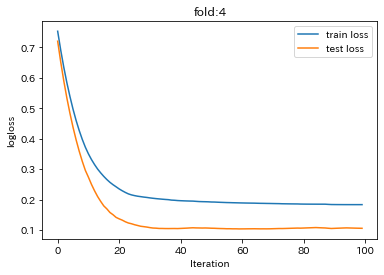

[I 2021-12-13 12:00:54,042] A new study created in memory with name: no-name-0c316055-70ca-46a1-a50c-6120aac539b1


Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:54,464] Trial 0 finished with value: 0.14160403736819202 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.14160403736819202.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129543	Test's rmse: 0.141604
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:54,907] Trial 1 finished with value: 0.14299614317024453 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.14160403736819202.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142043	Test's rmse: 0.142996
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:55,323] Trial 2 finished with value: 0.13763968960310372 and parameters: {'feature_fraction': 0.8}. Best is trial 2 with value: 0.13763968960310372.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127177	Test's rmse: 0.13764
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:55,702] Trial 3 finished with value: 0.1464444573886836 and parameters: {'feature_fraction': 0.6}. Best is trial 2 with value: 0.13763968960310372.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12406	Test's rmse: 0.146444
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:56,135] Trial 4 finished with value: 0.14159464829708093 and parameters: {'feature_fraction': 1.0}. Best is trial 2 with value: 0.13763968960310372.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.150049	Test's rmse: 0.141595
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:56,441] Trial 5 finished with value: 0.17690728708983564 and parameters: {'feature_fraction': 0.4}. Best is trial 2 with value: 0.13763968960310372.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143653	Test's rmse: 0.176907
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:56,791] Trial 6 finished with value: 0.1641673706474295 and parameters: {'feature_fraction': 0.5}. Best is trial 2 with value: 0.13763968960310372.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130235	Test's rmse: 0.164167
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:57,653] Trial 7 finished with value: 0.14614962964834 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.14614962964834.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137626	Test's rmse: 0.14615
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:00:59,302] Trial 8 finished with value: 0.14706113149097402 and parameters: {'num_leaves': 244}. Best is trial 7 with value: 0.14614962964834.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133053	Test's rmse: 0.147061
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:00,686] Trial 9 finished with value: 0.14939299937100026 and parameters: {'num_leaves': 188}. Best is trial 7 with value: 0.14614962964834.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134946	Test's rmse: 0.149393
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:01,888] Trial 10 finished with value: 0.146289098365506 and parameters: {'num_leaves': 154}. Best is trial 7 with value: 0.14614962964834.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135779	Test's rmse: 0.146289
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:02,383] Trial 11 finished with value: 0.14065053527872637 and parameters: {'num_leaves': 41}. Best is trial 11 with value: 0.14065053527872637.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12654	Test's rmse: 0.140651
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:02,940] Trial 12 finished with value: 0.14065053527872637 and parameters: {'num_leaves': 41}. Best is trial 11 with value: 0.14065053527872637.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12654	Test's rmse: 0.140651
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:03,231] Trial 13 finished with value: 0.14476838642180187 and parameters: {'num_leaves': 16}. Best is trial 11 with value: 0.14065053527872637.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14045	Test's rmse: 0.144768
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:04,842] Trial 14 finished with value: 0.14876146518694702 and parameters: {'num_leaves': 222}. Best is trial 11 with value: 0.14065053527872637.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137615	Test's rmse: 0.148761
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:06,089] Trial 15 finished with value: 0.1445535591466425 and parameters: {'num_leaves': 155}. Best is trial 11 with value: 0.14065053527872637.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131944	Test's rmse: 0.144554
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:07,456] Trial 16 finished with value: 0.14777872855675184 and parameters: {'num_leaves': 182}. Best is trial 11 with value: 0.14065053527872637.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135152	Test's rmse: 0.147779
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:08,205] Trial 17 finished with value: 0.14012222891797416 and parameters: {'num_leaves': 81}. Best is trial 17 with value: 0.14012222891797416.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.124884	Test's rmse: 0.140122
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:08,943] Trial 18 finished with value: 0.14556704123752193 and parameters: {'num_leaves': 79}. Best is trial 17 with value: 0.14012222891797416.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134086	Test's rmse: 0.145567
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:09,623] Trial 19 finished with value: 0.14706703599241797 and parameters: {'num_leaves': 70}. Best is trial 17 with value: 0.14012222891797416.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135463	Test's rmse: 0.147067
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:09,829] Trial 20 finished with value: 0.15353758612067148 and parameters: {'num_leaves': 6}. Best is trial 17 with value: 0.14012222891797416.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138955	Test's rmse: 0.153538
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:10,763] Trial 21 finished with value: 0.14618546647105143 and parameters: {'num_leaves': 112}. Best is trial 17 with value: 0.14012222891797416.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136408	Test's rmse: 0.146185
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:11,319] Trial 22 finished with value: 0.14469913956922162 and parameters: {'num_leaves': 46}. Best is trial 17 with value: 0.14012222891797416.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131961	Test's rmse: 0.144699
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:11,915] Trial 23 finished with value: 0.14420911121043276 and parameters: {'num_leaves': 53}. Best is trial 17 with value: 0.14012222891797416.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135351	Test's rmse: 0.144209
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:12,897] Trial 24 finished with value: 0.14501378502312992 and parameters: {'num_leaves': 119}. Best is trial 17 with value: 0.14012222891797416.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133957	Test's rmse: 0.145014
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:13,722] Trial 25 finished with value: 0.143775450201863 and parameters: {'num_leaves': 87}. Best is trial 17 with value: 0.14012222891797416.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135839	Test's rmse: 0.143775
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:14,170] Trial 26 finished with value: 0.13832982708742303 and parameters: {'num_leaves': 34}. Best is trial 26 with value: 0.13832982708742303.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126161	Test's rmse: 0.13833
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:14,636] Trial 27 finished with value: 0.16226752929682492 and parameters: {'bagging_fraction': 0.624724071308792, 'bagging_freq': 7}. Best is trial 27 with value: 0.16226752929682492.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.164647	Test's rmse: 0.162268
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:15,119] Trial 28 finished with value: 0.1552106416180538 and parameters: {'bagging_fraction': 0.8391963650875751, 'bagging_freq': 5}. Best is trial 28 with value: 0.1552106416180538.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148494	Test's rmse: 0.155211
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:15,595] Trial 29 finished with value: 0.15845903629845082 and parameters: {'bagging_fraction': 0.49361118426561795, 'bagging_freq': 2}. Best is trial 28 with value: 0.1552106416180538.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.175989	Test's rmse: 0.158459
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:16,080] Trial 30 finished with value: 0.15691365354991751 and parameters: {'bagging_fraction': 0.4348501673009778, 'bagging_freq': 7}. Best is trial 28 with value: 0.1552106416180538.


Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.180075	Test's rmse: 0.156914
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:16,534] Trial 31 finished with value: 0.15373613644293688 and parameters: {'bagging_fraction': 0.7606690070465265, 'bagging_freq': 5}. Best is trial 31 with value: 0.15373613644293688.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.160043	Test's rmse: 0.153736
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:17,001] Trial 32 finished with value: 0.15635099442471515 and parameters: {'bagging_fraction': 0.41235069657750206, 'bagging_freq': 7}. Best is trial 31 with value: 0.15373613644293688.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.185681	Test's rmse: 0.156351
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:17,496] Trial 33 finished with value: 0.14630291366941414 and parameters: {'bagging_fraction': 0.8994655844810855, 'bagging_freq': 2}. Best is trial 33 with value: 0.14630291366941414.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140849	Test's rmse: 0.146303
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:17,956] Trial 34 finished with value: 0.15725794345822192 and parameters: {'bagging_fraction': 0.5090949803244422, 'bagging_freq': 2}. Best is trial 33 with value: 0.14630291366941414.


Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.176469	Test's rmse: 0.157258
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:18,437] Trial 35 finished with value: 0.15612907508355875 and parameters: {'bagging_fraction': 0.5825453457760269, 'bagging_freq': 4}. Best is trial 33 with value: 0.14630291366941414.


Did not meet early stopping. Best iteration is:
[97]	Train's rmse: 0.170591	Test's rmse: 0.156129
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:18,907] Trial 36 finished with value: 0.15072951650532768 and parameters: {'bagging_fraction': 0.6591670111857015, 'bagging_freq': 3}. Best is trial 33 with value: 0.14630291366941414.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.165719	Test's rmse: 0.15073
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:19,363] Trial 37 finished with value: 0.14160927380052102 and parameters: {'feature_fraction': 0.88}. Best is trial 37 with value: 0.14160927380052102.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142043	Test's rmse: 0.141609
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:19,805] Trial 38 finished with value: 0.14160927380052102 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 37 with value: 0.14160927380052102.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142043	Test's rmse: 0.141609
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:20,237] Trial 39 finished with value: 0.14530508747993423 and parameters: {'feature_fraction': 0.784}. Best is trial 37 with value: 0.14160927380052102.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.122963	Test's rmse: 0.145305
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:20,683] Trial 40 finished with value: 0.13763968960310372 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 40 with value: 0.13763968960310372.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127177	Test's rmse: 0.13764
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:21,126] Trial 41 finished with value: 0.14530508747993423 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 40 with value: 0.13763968960310372.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.122963	Test's rmse: 0.145305
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:21,528] Trial 42 finished with value: 0.14160403736819202 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 40 with value: 0.13763968960310372.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129543	Test's rmse: 0.141604
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:21,943] Trial 43 finished with value: 0.1478758667739091 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403}. Best is trial 43 with value: 0.1478758667739091.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130558	Test's rmse: 0.147876
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:22,373] Trial 44 finished with value: 0.14067312491110337 and parameters: {'lambda_l1': 0.038720902953704193, 'lambda_l2': 0.0024430162614261413}. Best is trial 44 with value: 0.14067312491110337.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134606	Test's rmse: 0.140673
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:22,792] Trial 45 finished with value: 0.13763969009090646 and parameters: {'lambda_l1': 2.5361081166471375e-07, 'lambda_l2': 2.5348407664333426e-07}. Best is trial 45 with value: 0.13763969009090646.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127177	Test's rmse: 0.13764
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:23,221] Trial 46 finished with value: 0.14310207461736954 and parameters: {'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893}. Best is trial 45 with value: 0.13763969009090646.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.122952	Test's rmse: 0.143102
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:23,627] Trial 47 finished with value: 0.1383996826164627 and parameters: {'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682}. Best is trial 45 with value: 0.13763969009090646.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132229	Test's rmse: 0.1384
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:24,058] Trial 48 finished with value: 0.15521999156583083 and parameters: {'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285}. Best is trial 45 with value: 0.13763969009090646.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13153	Test's rmse: 0.15522
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:24,481] Trial 49 finished with value: 0.14077517495953606 and parameters: {'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07}. Best is trial 45 with value: 0.13763969009090646.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129208	Test's rmse: 0.140775
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:24,894] Trial 50 finished with value: 0.1376396903773751 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07}. Best is trial 45 with value: 0.13763969009090646.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127177	Test's rmse: 0.13764
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:25,335] Trial 51 finished with value: 0.13763990546778318 and parameters: {'lambda_l1': 5.472429642032198e-06, 'lambda_l2': 0.00052821153945323}. Best is trial 45 with value: 0.13763969009090646.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127178	Test's rmse: 0.13764
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:25,746] Trial 52 finished with value: 0.1412904490048807 and parameters: {'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06}. Best is trial 45 with value: 0.13763969009090646.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130267	Test's rmse: 0.14129
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:26,125] Trial 53 finished with value: 0.15231019703008647 and parameters: {'lambda_l1': 3.207959657544482, 'lambda_l2': 1.1323342574941946e-08}. Best is trial 45 with value: 0.13763969009090646.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129522	Test's rmse: 0.15231
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:26,556] Trial 54 finished with value: 0.13763969174607077 and parameters: {'lambda_l1': 8.739208840790941e-07, 'lambda_l2': 1.99371629285331e-06}. Best is trial 45 with value: 0.13763969009090646.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127177	Test's rmse: 0.13764
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:26,968] Trial 55 finished with value: 0.13763969017293448 and parameters: {'lambda_l1': 3.2956792945849545e-07, 'lambda_l2': 2.2311398834761413e-08}. Best is trial 45 with value: 0.13763969009090646.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127177	Test's rmse: 0.13764
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:27,400] Trial 56 finished with value: 0.14202393242398065 and parameters: {'lambda_l1': 0.0008421907750901968, 'lambda_l2': 1.2702524155028834e-08}. Best is trial 45 with value: 0.13763969009090646.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132518	Test's rmse: 0.142024
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:27,834] Trial 57 finished with value: 0.1376397001747369 and parameters: {'lambda_l1': 3.447615183683311e-07, 'lambda_l2': 2.6087844118276602e-05}. Best is trial 45 with value: 0.13763969009090646.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127177	Test's rmse: 0.13764
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:28,267] Trial 58 finished with value: 0.1376396973693814 and parameters: {'lambda_l1': 4.895525573655169e-06, 'lambda_l2': 1.3153049473274364e-07}. Best is trial 45 with value: 0.13763969009090646.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127177	Test's rmse: 0.13764
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:28,691] Trial 59 finished with value: 0.13763970377968732 and parameters: {'lambda_l1': 8.888685965689552e-08, 'lambda_l2': 3.59424753355417e-05}. Best is trial 45 with value: 0.13763969009090646.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127177	Test's rmse: 0.13764
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:29,114] Trial 60 finished with value: 0.14095820543866258 and parameters: {'lambda_l1': 0.00013207817698280088, 'lambda_l2': 6.182028633393764e-08}. Best is trial 45 with value: 0.13763969009090646.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130061	Test's rmse: 0.140958
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:29,543] Trial 61 finished with value: 0.1376397284112358 and parameters: {'lambda_l1': 4.976594151195463e-06, 'lambda_l2': 7.918734875085908e-05}. Best is trial 45 with value: 0.13763969009090646.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127177	Test's rmse: 0.13764
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:29,959] Trial 62 finished with value: 0.14004760186302204 and parameters: {'lambda_l1': 0.0057550268638067925, 'lambda_l2': 8.059918212278755e-08}. Best is trial 45 with value: 0.13763969009090646.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126847	Test's rmse: 0.140048
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:30,408] Trial 63 finished with value: 0.15329487627631488 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.15329487627631488.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14296	Test's rmse: 0.153295
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:30,827] Trial 64 finished with value: 0.1959963274823885 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.15329487627631488.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.282545	Test's rmse: 0.195996
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:31,200] Trial 65 finished with value: 0.15136536608243906 and parameters: {'min_child_samples': 5}. Best is trial 65 with value: 0.15136536608243906.


Early stopping, best iteration is:
[44]	Train's rmse: 0.0696555	Test's rmse: 0.151365
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:31,634] Trial 66 finished with value: 0.1769357356314001 and parameters: {'min_child_samples': 50}. Best is trial 65 with value: 0.15136536608243906.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.229073	Test's rmse: 0.176936
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:32,053] Trial 67 finished with value: 0.15330044238468538 and parameters: {'min_child_samples': 10}. Best is trial 65 with value: 0.15136536608243906.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0672151	Test's rmse: 0.1533


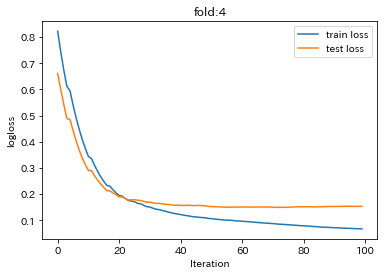

[I 2021-12-13 12:01:32,265] A new study created in memory with name: no-name-ded81f20-95e4-49a5-9b92-f6e754636162


Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:32,691] Trial 0 finished with value: 0.03695359888733015 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.03695359888733015.


Early stopping, best iteration is:
[44]	Train's rmse: 0.167775	Test's rmse: 0.0369536
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:33,099] Trial 1 finished with value: 0.022023373500889048 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 0.022023373500889048.


Early stopping, best iteration is:
[42]	Train's rmse: 0.171115	Test's rmse: 0.0220234
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:33,477] Trial 2 finished with value: 0.09047713157500001 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.022023373500889048.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134338	Test's rmse: 0.0904771
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:33,822] Trial 3 finished with value: 0.10127172897964562 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 0.022023373500889048.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135755	Test's rmse: 0.101272
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:34,237] Trial 4 finished with value: 0.05711482323434281 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 0.022023373500889048.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130676	Test's rmse: 0.0571148
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:34,596] Trial 5 finished with value: 0.105967076609913 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 0.022023373500889048.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139716	Test's rmse: 0.105967
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:34,983] Trial 6 finished with value: 0.07127204462101794 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 0.022023373500889048.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127681	Test's rmse: 0.071272
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:35,807] Trial 7 finished with value: 0.021458228126645506 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.021458228126645506.


Early stopping, best iteration is:
[43]	Train's rmse: 0.171715	Test's rmse: 0.0214582
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:37,380] Trial 8 finished with value: 0.02151589335465682 and parameters: {'num_leaves': 244}. Best is trial 7 with value: 0.021458228126645506.


Early stopping, best iteration is:
[44]	Train's rmse: 0.171535	Test's rmse: 0.0215159
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:38,733] Trial 9 finished with value: 0.021600662770029026 and parameters: {'num_leaves': 188}. Best is trial 7 with value: 0.021458228126645506.


Early stopping, best iteration is:
[47]	Train's rmse: 0.170526	Test's rmse: 0.0216007
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:39,867] Trial 10 finished with value: 0.021568773424831458 and parameters: {'num_leaves': 154}. Best is trial 7 with value: 0.021458228126645506.


Early stopping, best iteration is:
[44]	Train's rmse: 0.171425	Test's rmse: 0.0215688
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:40,347] Trial 11 finished with value: 0.021285827474809366 and parameters: {'num_leaves': 41}. Best is trial 11 with value: 0.021285827474809366.


Early stopping, best iteration is:
[43]	Train's rmse: 0.170905	Test's rmse: 0.0212858
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:40,835] Trial 12 finished with value: 0.021285827474809366 and parameters: {'num_leaves': 41}. Best is trial 11 with value: 0.021285827474809366.


Early stopping, best iteration is:
[43]	Train's rmse: 0.170905	Test's rmse: 0.0212858
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:41,127] Trial 13 finished with value: 0.01964588250250433 and parameters: {'num_leaves': 16}. Best is trial 13 with value: 0.01964588250250433.


Early stopping, best iteration is:
[45]	Train's rmse: 0.173795	Test's rmse: 0.0196459
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:42,616] Trial 14 finished with value: 0.021605477635390075 and parameters: {'num_leaves': 222}. Best is trial 13 with value: 0.01964588250250433.


Early stopping, best iteration is:
[47]	Train's rmse: 0.170525	Test's rmse: 0.0216055
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:43,750] Trial 15 finished with value: 0.02155395504331001 and parameters: {'num_leaves': 155}. Best is trial 13 with value: 0.01964588250250433.


Early stopping, best iteration is:
[44]	Train's rmse: 0.171425	Test's rmse: 0.021554
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:45,022] Trial 16 finished with value: 0.021508341861408067 and parameters: {'num_leaves': 182}. Best is trial 13 with value: 0.01964588250250433.


Early stopping, best iteration is:
[44]	Train's rmse: 0.171537	Test's rmse: 0.0215083
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:45,240] Trial 17 finished with value: 0.020768112337638416 and parameters: {'num_leaves': 7}. Best is trial 13 with value: 0.01964588250250433.
[I 2021-12-13 12:01:45,377] Trial 18 finished with value: 0.04647933587001448 and parameters: {'num_leaves': 2}. Best is trial 13 with value: 0.01964588250250433.


Early stopping, best iteration is:
[49]	Train's rmse: 0.174285	Test's rmse: 0.0207681
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.209583	Test's rmse: 0.0464793
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:46,156] Trial 19 finished with value: 0.021542787293398896 and parameters: {'num_leaves': 88}. Best is trial 13 with value: 0.01964588250250433.
[I 2021-12-13 12:01:46,313] Trial 20 finished with value: 0.04089268823335639 and parameters: {'num_leaves': 3}. Best is trial 13 with value: 0.01964588250250433.


Early stopping, best iteration is:
[43]	Train's rmse: 0.171719	Test's rmse: 0.0215428
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196137	Test's rmse: 0.0408927
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:46,865] Trial 21 finished with value: 0.021449155886468597 and parameters: {'num_leaves': 47}. Best is trial 13 with value: 0.01964588250250433.


Early stopping, best iteration is:
[45]	Train's rmse: 0.169929	Test's rmse: 0.0214492
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:47,583] Trial 22 finished with value: 0.021605644654172345 and parameters: {'num_leaves': 83}. Best is trial 13 with value: 0.01964588250250433.


Early stopping, best iteration is:
[42]	Train's rmse: 0.172302	Test's rmse: 0.0216056
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:48,226] Trial 23 finished with value: 0.02171196738921194 and parameters: {'num_leaves': 59}. Best is trial 13 with value: 0.01964588250250433.


Early stopping, best iteration is:
[47]	Train's rmse: 0.170187	Test's rmse: 0.021712
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:48,537] Trial 24 finished with value: 0.020360677588349838 and parameters: {'num_leaves': 19}. Best is trial 13 with value: 0.01964588250250433.


Early stopping, best iteration is:
[44]	Train's rmse: 0.167578	Test's rmse: 0.0203607
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:49,481] Trial 25 finished with value: 0.02164196616728896 and parameters: {'num_leaves': 114}. Best is trial 13 with value: 0.01964588250250433.


Early stopping, best iteration is:
[43]	Train's rmse: 0.171964	Test's rmse: 0.021642
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:50,101] Trial 26 finished with value: 0.021722179301192215 and parameters: {'num_leaves': 61}. Best is trial 13 with value: 0.01964588250250433.


Early stopping, best iteration is:
[42]	Train's rmse: 0.172147	Test's rmse: 0.0217222
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:50,410] Trial 27 finished with value: 0.03738717269491655 and parameters: {'bagging_fraction': 0.624724071308792, 'bagging_freq': 7}. Best is trial 27 with value: 0.03738717269491655.


Early stopping, best iteration is:
[42]	Train's rmse: 0.198159	Test's rmse: 0.0373872
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:50,769] Trial 28 finished with value: 0.0299120346401286 and parameters: {'bagging_fraction': 0.8391963650875751, 'bagging_freq': 5}. Best is trial 28 with value: 0.0299120346401286.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.170941	Test's rmse: 0.029912
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:51,123] Trial 29 finished with value: 0.02580107985438507 and parameters: {'bagging_fraction': 0.49361118426561795, 'bagging_freq': 2}. Best is trial 29 with value: 0.02580107985438507.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182706	Test's rmse: 0.0258011
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:51,455] Trial 30 finished with value: 0.024128954159694956 and parameters: {'bagging_fraction': 0.4348501673009778, 'bagging_freq': 7}. Best is trial 30 with value: 0.024128954159694956.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.184783	Test's rmse: 0.024129
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:51,812] Trial 31 finished with value: 0.03046807718831291 and parameters: {'bagging_fraction': 0.7606690070465265, 'bagging_freq': 5}. Best is trial 30 with value: 0.024128954159694956.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182903	Test's rmse: 0.0304681
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:52,161] Trial 32 finished with value: 0.031065908017735365 and parameters: {'bagging_fraction': 0.41235069657750206, 'bagging_freq': 7}. Best is trial 30 with value: 0.024128954159694956.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.189593	Test's rmse: 0.0310659
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:52,523] Trial 33 finished with value: 0.021020552454870396 and parameters: {'bagging_fraction': 0.8994655844810855, 'bagging_freq': 2}. Best is trial 33 with value: 0.021020552454870396.


Early stopping, best iteration is:
[48]	Train's rmse: 0.179022	Test's rmse: 0.0210206
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:52,856] Trial 34 finished with value: 0.031670588500563625 and parameters: {'bagging_fraction': 0.5090949803244422, 'bagging_freq': 2}. Best is trial 33 with value: 0.021020552454870396.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.181132	Test's rmse: 0.0316706
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:53,221] Trial 35 finished with value: 0.0317214981178914 and parameters: {'bagging_fraction': 0.5825453457760269, 'bagging_freq': 4}. Best is trial 33 with value: 0.021020552454870396.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.18153	Test's rmse: 0.0317215
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:53,557] Trial 36 finished with value: 0.03127724617955233 and parameters: {'bagging_fraction': 0.6591670111857015, 'bagging_freq': 3}. Best is trial 33 with value: 0.021020552454870396.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.178	Test's rmse: 0.0312772
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:53,857] Trial 37 finished with value: 0.033550505549685944 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 37 with value: 0.033550505549685944.


Early stopping, best iteration is:
[47]	Train's rmse: 0.167037	Test's rmse: 0.0335505
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:54,173] Trial 38 finished with value: 0.039859513635538156 and parameters: {'feature_fraction': 0.92}. Best is trial 37 with value: 0.033550505549685944.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142909	Test's rmse: 0.0398595
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:54,469] Trial 39 finished with value: 0.033550505549685944 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 37 with value: 0.033550505549685944.


Early stopping, best iteration is:
[47]	Train's rmse: 0.167037	Test's rmse: 0.0335505
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:54,769] Trial 40 finished with value: 0.026988311094487124 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403}. Best is trial 40 with value: 0.026988311094487124.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.151796	Test's rmse: 0.0269883
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:55,065] Trial 41 finished with value: 0.01957742976387724 and parameters: {'lambda_l1': 0.038720902953704193, 'lambda_l2': 0.0024430162614261413}. Best is trial 41 with value: 0.01957742976387724.


Early stopping, best iteration is:
[43]	Train's rmse: 0.16989	Test's rmse: 0.0195774
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:55,374] Trial 42 finished with value: 0.01964588267015898 and parameters: {'lambda_l1': 2.5361081166471375e-07, 'lambda_l2': 2.5348407664333426e-07}. Best is trial 41 with value: 0.01957742976387724.


Early stopping, best iteration is:
[45]	Train's rmse: 0.173795	Test's rmse: 0.0196459
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:55,646] Trial 43 finished with value: 0.020929741769547792 and parameters: {'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893}. Best is trial 41 with value: 0.01957742976387724.


Early stopping, best iteration is:
[42]	Train's rmse: 0.171205	Test's rmse: 0.0209297
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:55,930] Trial 44 finished with value: 0.02109288402228784 and parameters: {'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682}. Best is trial 41 with value: 0.01957742976387724.


Early stopping, best iteration is:
[41]	Train's rmse: 0.17214	Test's rmse: 0.0210929
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:56,243] Trial 45 finished with value: 0.026170512258721496 and parameters: {'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285}. Best is trial 41 with value: 0.01957742976387724.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15283	Test's rmse: 0.0261705
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:56,523] Trial 46 finished with value: 0.020755154092645934 and parameters: {'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07}. Best is trial 41 with value: 0.01957742976387724.


Early stopping, best iteration is:
[44]	Train's rmse: 0.171588	Test's rmse: 0.0207552
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:56,820] Trial 47 finished with value: 0.01964588278086277 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07}. Best is trial 41 with value: 0.01957742976387724.


Early stopping, best iteration is:
[45]	Train's rmse: 0.173795	Test's rmse: 0.0196459
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:57,129] Trial 48 finished with value: 0.019645894819603327 and parameters: {'lambda_l1': 5.472429642032198e-06, 'lambda_l2': 0.00052821153945323}. Best is trial 41 with value: 0.01957742976387724.


Early stopping, best iteration is:
[45]	Train's rmse: 0.173795	Test's rmse: 0.0196459
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:57,421] Trial 49 finished with value: 0.01964592069663114 and parameters: {'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06}. Best is trial 41 with value: 0.01957742976387724.


Early stopping, best iteration is:
[45]	Train's rmse: 0.173795	Test's rmse: 0.0196459
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:57,703] Trial 50 finished with value: 0.027165234668499315 and parameters: {'lambda_l1': 5.402896923508629, 'lambda_l2': 0.00018194741639177489}. Best is trial 41 with value: 0.01957742976387724.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139738	Test's rmse: 0.0271652
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:58,021] Trial 51 finished with value: 0.0198970876151906 and parameters: {'lambda_l1': 0.006742720353084154, 'lambda_l2': 1.2434696409427858e-08}. Best is trial 41 with value: 0.01957742976387724.


Early stopping, best iteration is:
[45]	Train's rmse: 0.173165	Test's rmse: 0.0198971
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:58,307] Trial 52 finished with value: 0.020318235922957756 and parameters: {'lambda_l1': 0.03666033149805631, 'lambda_l2': 0.001190230579501886}. Best is trial 41 with value: 0.01957742976387724.


Early stopping, best iteration is:
[44]	Train's rmse: 0.168726	Test's rmse: 0.0203182
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:58,602] Trial 53 finished with value: 0.019895811112392088 and parameters: {'lambda_l1': 0.0008421907750901968, 'lambda_l2': 3.404677878190547e-05}. Best is trial 41 with value: 0.01957742976387724.


Early stopping, best iteration is:
[45]	Train's rmse: 0.173156	Test's rmse: 0.0198958
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:58,893] Trial 54 finished with value: 0.020727141675191005 and parameters: {'lambda_l1': 2.236019245174549e-06, 'lambda_l2': 0.044223173270844754}. Best is trial 41 with value: 0.01957742976387724.


Early stopping, best iteration is:
[43]	Train's rmse: 0.169687	Test's rmse: 0.0207271
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:59,175] Trial 55 finished with value: 0.02132406381798077 and parameters: {'lambda_l1': 0.2992697206188339, 'lambda_l2': 1.4569041111599704e-08}. Best is trial 41 with value: 0.01957742976387724.


Early stopping, best iteration is:
[44]	Train's rmse: 0.16841	Test's rmse: 0.0213241
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:59,471] Trial 56 finished with value: 0.01977313509986161 and parameters: {'lambda_l1': 3.031520278727039e-07, 'lambda_l2': 0.010939608734528681}. Best is trial 41 with value: 0.01957742976387724.


Early stopping, best iteration is:
[45]	Train's rmse: 0.173138	Test's rmse: 0.0197731
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:01:59,761] Trial 57 finished with value: 0.019645971650440835 and parameters: {'lambda_l1': 0.00017964951948595568, 'lambda_l2': 2.44444031921085e-05}. Best is trial 41 with value: 0.01957742976387724.


Early stopping, best iteration is:
[45]	Train's rmse: 0.173795	Test's rmse: 0.019646
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:00,076] Trial 58 finished with value: 0.02035409611771826 and parameters: {'lambda_l1': 0.020087954390907665, 'lambda_l2': 2.5408716217151766e-07}. Best is trial 41 with value: 0.01957742976387724.


Early stopping, best iteration is:
[43]	Train's rmse: 0.170587	Test's rmse: 0.0203541
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:00,346] Trial 59 finished with value: 0.021371688619532356 and parameters: {'lambda_l1': 0.252450628010636, 'lambda_l2': 0.0033921454183425564}. Best is trial 41 with value: 0.01957742976387724.


Early stopping, best iteration is:
[46]	Train's rmse: 0.168612	Test's rmse: 0.0213717
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:00,665] Trial 60 finished with value: 0.025479067481501878 and parameters: {'min_child_samples': 25}. Best is trial 60 with value: 0.025479067481501878.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.171197	Test's rmse: 0.0254791
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:00,938] Trial 61 finished with value: 0.028663669255843547 and parameters: {'min_child_samples': 10}. Best is trial 60 with value: 0.025479067481501878.


Early stopping, best iteration is:
[40]	Train's rmse: 0.110873	Test's rmse: 0.0286637
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:01,253] Trial 62 finished with value: 0.08413231311973987 and parameters: {'min_child_samples': 100}. Best is trial 60 with value: 0.025479067481501878.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.29479	Test's rmse: 0.0841323
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:01,504] Trial 63 finished with value: 0.030003483436000726 and parameters: {'min_child_samples': 5}. Best is trial 60 with value: 0.025479067481501878.


Early stopping, best iteration is:
[38]	Train's rmse: 0.0636493	Test's rmse: 0.0300035
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:01,793] Trial 64 finished with value: 0.055352892172707 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 0.025479067481501878.


Early stopping, best iteration is:
[39]	Train's rmse: 0.259273	Test's rmse: 0.0553529


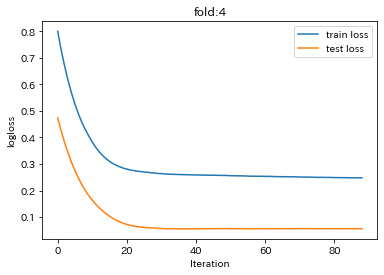

[I 2021-12-13 12:02:01,977] A new study created in memory with name: no-name-165e1b5e-306c-4788-bdf3-fdc379c31d5c


Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:02,409] Trial 0 finished with value: 0.39429631239948043 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.39429631239948043.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.121089	Test's rmse: 0.394296
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:02,737] Trial 1 finished with value: 0.4197066103870832 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.39429631239948043.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.125498	Test's rmse: 0.419707
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:03,089] Trial 2 finished with value: 0.4170792688972279 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.39429631239948043.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.124117	Test's rmse: 0.417079
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:03,491] Trial 3 finished with value: 0.3778118242406942 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 3 with value: 0.3778118242406942.


Early stopping, best iteration is:
[36]	Train's rmse: 0.158307	Test's rmse: 0.377812
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:03,877] Trial 4 finished with value: 0.38205205563109934 and parameters: {'feature_fraction': 0.8}. Best is trial 3 with value: 0.3778118242406942.


Early stopping, best iteration is:
[43]	Train's rmse: 0.153638	Test's rmse: 0.382052
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:04,264] Trial 5 finished with value: 0.39812155447472136 and parameters: {'feature_fraction': 0.6}. Best is trial 3 with value: 0.3778118242406942.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119276	Test's rmse: 0.398122
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:04,666] Trial 6 finished with value: 0.37077356770919284 and parameters: {'feature_fraction': 1.0}. Best is trial 6 with value: 0.37077356770919284.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159528	Test's rmse: 0.370774
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:05,445] Trial 7 finished with value: 0.3736801139470076 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.3736801139470076.


Early stopping, best iteration is:
[37]	Train's rmse: 0.154394	Test's rmse: 0.37368
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:06,822] Trial 8 finished with value: 0.3744959650664826 and parameters: {'num_leaves': 244}. Best is trial 7 with value: 0.3736801139470076.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159027	Test's rmse: 0.374496
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:07,946] Trial 9 finished with value: 0.3744957958435846 and parameters: {'num_leaves': 188}. Best is trial 7 with value: 0.3736801139470076.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159028	Test's rmse: 0.374496
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:08,934] Trial 10 finished with value: 0.37449529260838316 and parameters: {'num_leaves': 154}. Best is trial 7 with value: 0.3736801139470076.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159029	Test's rmse: 0.374495
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:09,384] Trial 11 finished with value: 0.3751762740389383 and parameters: {'num_leaves': 41}. Best is trial 7 with value: 0.3736801139470076.


Early stopping, best iteration is:
[31]	Train's rmse: 0.160894	Test's rmse: 0.375176
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:09,809] Trial 12 finished with value: 0.3751762740389383 and parameters: {'num_leaves': 41}. Best is trial 7 with value: 0.3736801139470076.


Early stopping, best iteration is:
[31]	Train's rmse: 0.160894	Test's rmse: 0.375176
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:10,080] Trial 13 finished with value: 0.37402943945978134 and parameters: {'num_leaves': 16}. Best is trial 7 with value: 0.3736801139470076.


Early stopping, best iteration is:
[30]	Train's rmse: 0.162291	Test's rmse: 0.374029
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:11,345] Trial 14 finished with value: 0.3744959446418687 and parameters: {'num_leaves': 222}. Best is trial 7 with value: 0.3736801139470076.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159027	Test's rmse: 0.374496
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:12,322] Trial 15 finished with value: 0.3744952108688714 and parameters: {'num_leaves': 155}. Best is trial 7 with value: 0.3736801139470076.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159029	Test's rmse: 0.374495
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:13,417] Trial 16 finished with value: 0.3744958632600006 and parameters: {'num_leaves': 182}. Best is trial 7 with value: 0.3736801139470076.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159028	Test's rmse: 0.374496
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:14,176] Trial 17 finished with value: 0.3736801139470076 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.3736801139470076.


Early stopping, best iteration is:
[37]	Train's rmse: 0.154394	Test's rmse: 0.37368
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:14,973] Trial 18 finished with value: 0.3737958972713638 and parameters: {'num_leaves': 98}. Best is trial 7 with value: 0.3736801139470076.


Early stopping, best iteration is:
[37]	Train's rmse: 0.154606	Test's rmse: 0.373796
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:15,665] Trial 19 finished with value: 0.3744962323696725 and parameters: {'num_leaves': 91}. Best is trial 7 with value: 0.3736801139470076.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159063	Test's rmse: 0.374496
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:16,511] Trial 20 finished with value: 0.37368549050204686 and parameters: {'num_leaves': 104}. Best is trial 7 with value: 0.3736801139470076.


Early stopping, best iteration is:
[37]	Train's rmse: 0.154428	Test's rmse: 0.373685
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:17,125] Trial 21 finished with value: 0.3737388513978505 and parameters: {'num_leaves': 68}. Best is trial 7 with value: 0.3736801139470076.


Early stopping, best iteration is:
[37]	Train's rmse: 0.154622	Test's rmse: 0.373739
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:18,023] Trial 22 finished with value: 0.3736685595853666 and parameters: {'num_leaves': 125}. Best is trial 22 with value: 0.3736685595853666.


Early stopping, best iteration is:
[37]	Train's rmse: 0.15439	Test's rmse: 0.373669
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:18,965] Trial 23 finished with value: 0.37369419151662386 and parameters: {'num_leaves': 133}. Best is trial 22 with value: 0.3736685595853666.


Early stopping, best iteration is:
[37]	Train's rmse: 0.154405	Test's rmse: 0.373694
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:19,861] Trial 24 finished with value: 0.37379125366389016 and parameters: {'num_leaves': 119}. Best is trial 22 with value: 0.3736685595853666.


Early stopping, best iteration is:
[37]	Train's rmse: 0.154578	Test's rmse: 0.373791
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:20,458] Trial 25 finished with value: 0.3733125019969782 and parameters: {'num_leaves': 62}. Best is trial 25 with value: 0.3733125019969782.


Early stopping, best iteration is:
[37]	Train's rmse: 0.154322	Test's rmse: 0.373313
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:21,049] Trial 26 finished with value: 0.37376037945144264 and parameters: {'num_leaves': 61}. Best is trial 25 with value: 0.3733125019969782.


Early stopping, best iteration is:
[37]	Train's rmse: 0.154646	Test's rmse: 0.37376
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:21,535] Trial 27 finished with value: 0.33082426453540353 and parameters: {'bagging_fraction': 0.624724071308792, 'bagging_freq': 7}. Best is trial 27 with value: 0.33082426453540353.


Early stopping, best iteration is:
[46]	Train's rmse: 0.182192	Test's rmse: 0.330824
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:22,082] Trial 28 finished with value: 0.35426512470625365 and parameters: {'bagging_fraction': 0.8391963650875751, 'bagging_freq': 5}. Best is trial 27 with value: 0.33082426453540353.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148469	Test's rmse: 0.354265
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:22,601] Trial 29 finished with value: 0.3446938688010536 and parameters: {'bagging_fraction': 0.49361118426561795, 'bagging_freq': 2}. Best is trial 27 with value: 0.33082426453540353.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.1706	Test's rmse: 0.344694
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:23,052] Trial 30 finished with value: 0.3496365012410951 and parameters: {'bagging_fraction': 0.4348501673009778, 'bagging_freq': 7}. Best is trial 27 with value: 0.33082426453540353.


Early stopping, best iteration is:
[41]	Train's rmse: 0.193624	Test's rmse: 0.349637
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:23,572] Trial 31 finished with value: 0.34921508497232184 and parameters: {'bagging_fraction': 0.7606690070465265, 'bagging_freq': 5}. Best is trial 27 with value: 0.33082426453540353.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.156764	Test's rmse: 0.349215
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:24,059] Trial 32 finished with value: 0.3510528101097551 and parameters: {'bagging_fraction': 0.41235069657750206, 'bagging_freq': 7}. Best is trial 27 with value: 0.33082426453540353.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.176584	Test's rmse: 0.351053
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:24,564] Trial 33 finished with value: 0.3593382213782176 and parameters: {'bagging_fraction': 0.8994655844810855, 'bagging_freq': 2}. Best is trial 27 with value: 0.33082426453540353.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141654	Test's rmse: 0.359338
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:25,101] Trial 34 finished with value: 0.3496896437041243 and parameters: {'bagging_fraction': 0.5090949803244422, 'bagging_freq': 2}. Best is trial 27 with value: 0.33082426453540353.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168267	Test's rmse: 0.34969
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:25,594] Trial 35 finished with value: 0.3590744180031663 and parameters: {'bagging_fraction': 0.5825453457760269, 'bagging_freq': 4}. Best is trial 27 with value: 0.33082426453540353.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.163977	Test's rmse: 0.359074
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:26,139] Trial 36 finished with value: 0.3603816362885704 and parameters: {'bagging_fraction': 0.6591670111857015, 'bagging_freq': 3}. Best is trial 27 with value: 0.33082426453540353.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.160598	Test's rmse: 0.360382
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:26,622] Trial 37 finished with value: 0.3489307016833639 and parameters: {'feature_fraction': 0.92}. Best is trial 37 with value: 0.3489307016833639.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.161556	Test's rmse: 0.348931
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:27,084] Trial 38 finished with value: 0.335307609011596 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 38 with value: 0.335307609011596.


Early stopping, best iteration is:
[42]	Train's rmse: 0.184213	Test's rmse: 0.335308
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:27,561] Trial 39 finished with value: 0.335307609011596 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 38 with value: 0.335307609011596.


Early stopping, best iteration is:
[42]	Train's rmse: 0.184213	Test's rmse: 0.335308
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:28,036] Trial 40 finished with value: 0.32943191935200394 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403}. Best is trial 40 with value: 0.32943191935200394.


Early stopping, best iteration is:
[41]	Train's rmse: 0.185001	Test's rmse: 0.329432
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:28,469] Trial 41 finished with value: 0.33171580075843055 and parameters: {'lambda_l1': 0.038720902953704193, 'lambda_l2': 0.0024430162614261413}. Best is trial 40 with value: 0.32943191935200394.


Early stopping, best iteration is:
[49]	Train's rmse: 0.180458	Test's rmse: 0.331716
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:28,973] Trial 42 finished with value: 0.33082426464573744 and parameters: {'lambda_l1': 2.5361081166471375e-07, 'lambda_l2': 2.5348407664333426e-07}. Best is trial 40 with value: 0.32943191935200394.


Early stopping, best iteration is:
[46]	Train's rmse: 0.182192	Test's rmse: 0.330824
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:29,473] Trial 43 finished with value: 0.3437747636123598 and parameters: {'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893}. Best is trial 40 with value: 0.32943191935200394.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.162266	Test's rmse: 0.343775
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:29,947] Trial 44 finished with value: 0.33532554205017706 and parameters: {'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682}. Best is trial 40 with value: 0.32943191935200394.


Early stopping, best iteration is:
[42]	Train's rmse: 0.182231	Test's rmse: 0.335326
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:30,364] Trial 45 finished with value: 0.3284463363967226 and parameters: {'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285}. Best is trial 45 with value: 0.3284463363967226.


Early stopping, best iteration is:
[42]	Train's rmse: 0.186455	Test's rmse: 0.328446
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:30,742] Trial 46 finished with value: 0.33324630307403946 and parameters: {'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07}. Best is trial 45 with value: 0.3284463363967226.


Early stopping, best iteration is:
[42]	Train's rmse: 0.181725	Test's rmse: 0.333246
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:31,239] Trial 47 finished with value: 0.33082426485883565 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07}. Best is trial 45 with value: 0.3284463363967226.


Early stopping, best iteration is:
[46]	Train's rmse: 0.182192	Test's rmse: 0.330824
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:31,710] Trial 48 finished with value: 0.3329765531585647 and parameters: {'lambda_l1': 5.472429642032198e-06, 'lambda_l2': 0.00052821153945323}. Best is trial 45 with value: 0.3284463363967226.


Early stopping, best iteration is:
[42]	Train's rmse: 0.183958	Test's rmse: 0.332977
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:32,202] Trial 49 finished with value: 0.33082432017999175 and parameters: {'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06}. Best is trial 45 with value: 0.3284463363967226.


Early stopping, best iteration is:
[46]	Train's rmse: 0.182192	Test's rmse: 0.330824
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:32,488] Trial 50 finished with value: 0.3375707549161965 and parameters: {'lambda_l1': 3.207959657544482, 'lambda_l2': 0.08430920984585018}. Best is trial 45 with value: 0.3284463363967226.


Early stopping, best iteration is:
[42]	Train's rmse: 0.178393	Test's rmse: 0.337571
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:32,926] Trial 51 finished with value: 0.327939014120243 and parameters: {'lambda_l1': 1.1692997958212103e-08, 'lambda_l2': 3.9472261531899844}. Best is trial 51 with value: 0.327939014120243.


Early stopping, best iteration is:
[42]	Train's rmse: 0.184969	Test's rmse: 0.327939
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:33,398] Trial 52 finished with value: 0.3443133006621765 and parameters: {'lambda_l1': 1.350995536870054e-08, 'lambda_l2': 1.475649304728376}. Best is trial 51 with value: 0.327939014120243.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.162321	Test's rmse: 0.344313
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:33,788] Trial 53 finished with value: 0.3318492813205051 and parameters: {'lambda_l1': 9.352650596074993e-07, 'lambda_l2': 7.577835796854522}. Best is trial 51 with value: 0.327939014120243.


Early stopping, best iteration is:
[41]	Train's rmse: 0.189926	Test's rmse: 0.331849
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:34,249] Trial 54 finished with value: 0.33486879281043785 and parameters: {'lambda_l1': 0.0008472745658933207, 'lambda_l2': 2.6087844118276602e-05}. Best is trial 51 with value: 0.327939014120243.


Early stopping, best iteration is:
[42]	Train's rmse: 0.182864	Test's rmse: 0.334869
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:34,708] Trial 55 finished with value: 0.33142491081804043 and parameters: {'lambda_l1': 1.1916519926516243e-08, 'lambda_l2': 0.055318243832778495}. Best is trial 51 with value: 0.327939014120243.


Early stopping, best iteration is:
[44]	Train's rmse: 0.181966	Test's rmse: 0.331425
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:35,194] Trial 56 finished with value: 0.3353285380100823 and parameters: {'lambda_l1': 3.7384258928166384e-06, 'lambda_l2': 0.004849463006735859}. Best is trial 51 with value: 0.327939014120243.


Early stopping, best iteration is:
[42]	Train's rmse: 0.18307	Test's rmse: 0.335329
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:35,637] Trial 57 finished with value: 0.33536075678529537 and parameters: {'lambda_l1': 1.8796187625037182e-07, 'lambda_l2': 0.4164249158976615}. Best is trial 51 with value: 0.327939014120243.


Early stopping, best iteration is:
[42]	Train's rmse: 0.182451	Test's rmse: 0.335361
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:36,147] Trial 58 finished with value: 0.3308242644882397 and parameters: {'lambda_l1': 1.197340518782296e-07, 'lambda_l2': 3.551686739770963e-08}. Best is trial 51 with value: 0.327939014120243.


Early stopping, best iteration is:
[46]	Train's rmse: 0.182192	Test's rmse: 0.330824
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:36,587] Trial 59 finished with value: 0.33499403428112645 and parameters: {'lambda_l1': 0.008177230105140616, 'lambda_l2': 3.613808583865736e-05}. Best is trial 51 with value: 0.327939014120243.


Early stopping, best iteration is:
[42]	Train's rmse: 0.182831	Test's rmse: 0.334994
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:37,107] Trial 60 finished with value: 0.42899827455263184 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 0.42899827455263184.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.214776	Test's rmse: 0.428998
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:37,514] Trial 61 finished with value: 0.38130080968487146 and parameters: {'min_child_samples': 5}. Best is trial 61 with value: 0.38130080968487146.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.067355	Test's rmse: 0.381301
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:38,034] Trial 62 finished with value: 0.5225325035355793 and parameters: {'min_child_samples': 100}. Best is trial 61 with value: 0.38130080968487146.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.271496	Test's rmse: 0.522533
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:38,468] Trial 63 finished with value: 0.3640770980705694 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.3640770980705694.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.121907	Test's rmse: 0.364077
Training until validation scores don't improve for 50 rounds.


[I 2021-12-13 12:02:38,922] Trial 64 finished with value: 0.3451271987116685 and parameters: {'min_child_samples': 25}. Best is trial 64 with value: 0.3451271987116685.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168684	Test's rmse: 0.345127


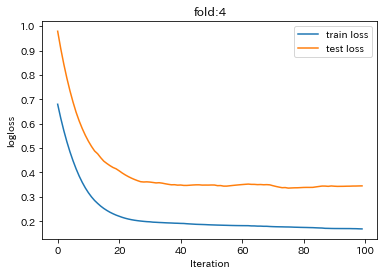

RMSE: [0.3123315737183189, 0.08873015539286183, 0.13763968960310372, 0.019577429763877194, 0.32793901412024307]
RMSE: 0.17724357251968095
elapsed_time:249.1[sec]


In [ ]:
# 経過時間の測定
start = time.time()

# 学習・推論
gkf = GroupKFold(n_splits=5)

groups = X_train_ce["Genre"]

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': 'rmse',             # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'deterministic':True,         # 再現性確保用のパラメータ
          'force_row_wise':True,        # 再現性確保用のパラメータ
          'seed': SEED                  # シード値
          }

best_params, history = {}, []

cv_result_quant = []

for train_index, test_index in gkf.split(X_train_ce, y_train, groups):
    X_train_gkf, X_test_gkf = X_train_ce.iloc[train_index], X_train_ce.iloc[test_index]
    y_train_gkf, y_test_gkf = y_train.iloc[train_index], y_train.iloc[test_index]

    # 学習、推論
    lgb_train = lgb.Dataset(X_train_gkf, y_train_gkf)
    lgb_test = lgb.Dataset(X_test_gkf, y_test_gkf, reference=lgb_train)

    model = lgb.LightGBMTuner(
                    params,                           # ハイパーパラメータをセット
                    train_set = lgb_train,            # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    early_stopping_rounds=50,         # アーリーストッピング設定
                    evals_result=lgb_results,
                    verbose_eval=-1,                  # ログを最後の1つだけ表示
                    show_progress_bar = False,        # ログの非表示
                    optuna_seed=SEED,
                    )
    
    # 訓練の実施
    model.run()
    
    best_params = model.best_params

   # 損失推移を表示
    loss_train = lgb_results['Train']['rmse']
    loss_test = lgb_results['Test']['rmse']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('logloss')

    plt.title(f"fold:{fold}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='test loss')
    
    plt.legend()
    plt.show()

    # 推論
    best_model = model.get_best_booster()

    y_pred = best_model.predict(X_test_gkf)

    # 評価
    rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
    cv_result_quant.append(rmse)

print("RMSE:", cv_result_quant)
print("RMSE:", np.mean(cv_result_quant))

# 経過時間の測定
elasped_time_quant = round((time.time() - start), 1)

print(f"elapsed_time:{elasped_time_quant}[sec]")

In [ ]:
print("float64 RMSE:", round(np.mean(cv_result), 5))
print(f"float64 経過時間:{elasped_time}秒")

print("float16 RMSE:", round(np.mean(cv_result_quant), 5))
print(f"float16 経過時間:{elasped_time_quant}秒")

float64 RMSE: 0.18226
float64 経過時間:163.0秒
float16 RMSE: 0.17724
float16 経過時間:249.1秒
